In [1]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Temperature_summer_hourly.csv')

This meteorological dataset comes from the **Max Planck Institute**, and it can be found at [https://www.bgc-jena.mpg.de/wetter/](https://www.bgc-jena.mpg.de/wetter/). Our goal is to **predict temperature using meteorological variables**.

### A. Summarize the data. How much data is present? What attributes/features are continuous valued? Which attributes are categorical? [5 points] 

**Data Summary**  
The dataset contains **2,207 rows** and **22 columns**. It includes both continuous (numerical) attributes and categorical attributes.

**Continuous Attributes (Numerical Features)**  
The following features contain continuous values:  
- **p (mbar)**: Pressure in millibars  
- **T (degC)**: Temperature in degrees Celsius  
- **Tdew (degC)**: Dew point temperature in degrees Celsius  
- **rh (%)**: Relative humidity percentage  
- **wv (m/s)**: Wind velocity in meters per second  
- **rain (mm)**: Rainfall in millimeters  
- **SWDR (W/m²)**: Shortwave downward radiation in watts per square meter  
- **PAR (µmol/m²/s)**: Photosynthetically active radiation in micromoles per square meter per second  
- **CO2 (ppm)**: Carbon dioxide concentration in parts per million  

**Categorical Attributes (Non-Numerical Features)**  
The dataset contains **one categorical attribute**:  
- **Date Time**: A timestamp indicating the date and time of the measurement.  


In [3]:
# Get an overview of the dataset
summary = df.describe(include='all')  # Includes both numerical and categorical statistics
num_rows, num_cols = df.shape  # Get the number of rows and columns

# Identify continuous (numerical) and categorical attributes
continuous_features = df.select_dtypes(include=['number']).columns.tolist()
categorical_features = df.select_dtypes(exclude=['number']).columns.tolist()

# Print summary information
print(f"Total data points: {num_rows} rows, {num_cols} columns\n")
print(f"Continuous attributes: {continuous_features}\n")
print(f"Categorical attributes: {categorical_features}\n")


Total data points: 2207 rows, 10 columns

Continuous attributes: ['p (mbar)', 'T (degC)', 'Tdew (degC)', 'rh (%)', 'wv (m/s)', 'rain (mm)', 'SWDR (W/m²)', 'PAR (µmol/m²/s)', 'CO2 (ppm)']

Categorical attributes: ['Date Time']



The task is to build a model to predict **'T (degC)'** based on the given attributes/features:  
**'p (mbar)', 'Tdew (degC)', 'rh (%)', 'wv (m/s)', 'rain (mm)', 'SWDR (W/m²)', 'PAR (µmol/m²/s)', 'CO2 (ppm)'**, while ignoring the **'Date Time'** attribute.

### B. Display the statistical values for each of the attributes, along with visualizations (e.g., histogram) of the distributions for each attribute. Explain noticeable traits for key attributes. Are there any attributes that might require special treatment? If so, what special treatment might they require? [5 points]

**Notable Traits for Key Attributes:**
- **Pressure (p (mbar)):** Normally distributed with values ranging from 975.87 mbar to 1003.6 mbar. No significant outliers.
- **Temperature (T (degC)):** Symmetrical distribution resembling a normal curve, with a range of 4.68°C to 32.81°C.
- **Dew Point Temperature (Tdew (degC)):** Closely follows temperature distribution, as expected in meteorological data.
- **Relative Humidity (rh (%)):** Right-skewed distribution, with values between 30.22% and 99.9%, indicating high humidity is more common.
- **Wind Velocity (wv (m/s)):** Right-skewed, with many low-speed occurrences and a maximum of 9.19 m/s.
- **Rainfall (rain (mm)):** Mostly zero values, but occasional extreme values suggest variability in precipitation events.
- **Shortwave Downward Radiation (SWDR (W/m²)) & Photosynthetically Active Radiation (PAR (µmol/m²/s)):** Highly skewed, with most values near zero, reflecting strong time dependency (day vs. night).
- **CO₂ Concentration (CO2 (ppm)):** Extreme negative values (e.g., -9999 ppm) indicate erroneous placeholder values, requiring correction.

**Potential Special Treatments:**
**Handling Missing/Invalid Values:**

- Remove or replace CO₂ (CO2 (ppm)) values of -9999 (likely sensor errors).
- Rainfall (rain (mm)) has many zero values, requiring careful interpretation in modeling.

**Log Transformation for Skewed Distributions:**

- rain (mm), SWDR (W/m²), and PAR (µmol/m²/s) show right-skewed distributions. Applying log transformation can help normalize these features.

**Time-Dependent Analysis:**

- Solar radiation (SWDR) and PAR depend on time of day. Separating daytime and nighttime data could improve analysis.

**Standardization for High-Variance Features:**

- Wind speed (wv (m/s)) and rain (mm) have high variance, which may require z-score normalization for machine learning applications.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2207 entries, 0 to 2206
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date Time        2207 non-null   object 
 1   p (mbar)         2207 non-null   float64
 2   T (degC)         2207 non-null   float64
 3   Tdew (degC)      2207 non-null   float64
 4   rh (%)           2207 non-null   float64
 5   wv (m/s)         2207 non-null   float64
 6   rain (mm)        2207 non-null   float64
 7   SWDR (W/m²)      2207 non-null   float64
 8   PAR (µmol/m²/s)  2207 non-null   float64
 9   CO2 (ppm)        2207 non-null   float64
dtypes: float64(9), object(1)
memory usage: 172.6+ KB


In [5]:
df.head()

Date Time  p (mbar)  T (degC)  Tdew (degC)  rh (%)  wv (m/s)  \
0  2009-07-01 01:00:00    993.58     17.22        14.40    83.5      1.92   
1  2009-07-01 02:00:00    993.66     16.32        14.47    88.8      0.56   
2  2009-07-01 03:00:00    993.73     15.61        14.16    91.1      1.95   
3  2009-07-01 04:00:00    993.59     15.05        13.86    92.6      0.82   
4  2009-07-01 05:00:00    993.90     14.74        13.95    95.0      0.33   

   rain (mm)  SWDR (W/m²)  PAR (µmol/m²/s)  CO2 (ppm)  
0        0.0         0.00             0.00      409.0  
1        0.0         0.00             0.00      440.3  
2        0.0         0.00             0.00      425.1  
3        0.0         0.00             3.47      433.6  
4        0.0        31.19            75.87      479.6

In [6]:
df.describe()

p (mbar)     T (degC)  Tdew (degC)       rh (%)     wv (m/s)  \
count  2207.000000  2207.000000  2207.000000  2207.000000  2207.000000   
mean    990.643498    17.091767    11.294608    71.373036     1.843158   
std       5.294028     4.951882     2.903943    17.661389     1.388734   
min     975.870000     4.680000     4.440000    30.220000     0.000000   
25%     987.130000    13.410000     9.110000    57.715000     0.815000   
50%     990.600000    16.630000    11.210000    73.500000     1.540000   
75%     994.640000    20.485000    13.405000    86.200000     2.555000   
max    1003.600000    32.810000    19.390000    99.900000     9.190000   

         rain (mm)  SWDR (W/m²)  PAR (µmol/m²/s)    CO2 (ppm)  
count  2207.000000  2207.000000      2207.000000  2207.000000  
mean      0.016765   181.016262       361.686787   343.588672  
std       0.315309   241.115746       476.599468   732.539607  
min       0.000000     0.000000         0.000000 -9999.000000  
25%       0.000000     0.000000         0.000000   378.300000  
50%       0.000000    45.470000       100.390000   387.100000  
75%       0.000000   308.050000       613.800000   405.350000  
max      14.000000  1067.810000      2073.360000   521.200000

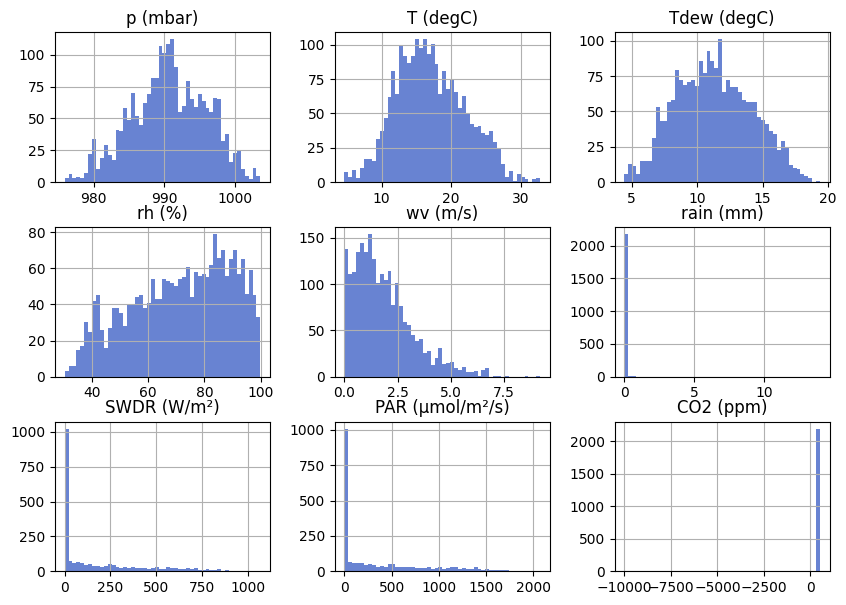

In [7]:
df_selected = df.drop(columns=["Date Time"])
ax = df_selected.hist(bins=50, figsize=(10, 7), color='#6883d2', grid=True)

### C. Analyze the relationships between the data attributes, and between the data attributes and label. This involves computing the Pearson Correlation Coefficient (PCC) and generating scatter plots. [5 points]

In [8]:
# Drop the outliers in df_selected where 'CO2 (ppm)' = -9999 in Question B.
df_selected2 = df_selected[df_selected['CO2 (ppm)'] != -9999.000000]

**1. Relationship Between Attributes and Target Variable (T (degC))**

**Strongest Positive Correlations with T (degC):**

- Tdew (degC) (+0.49): Higher dew point temperatures generally indicate higher air temperatures, explaining this strong correlation.
- SWDR (W/m²) & PAR (µmol/m²/s) (+0.53 each): Solar radiation and photosynthetically active radiation are positively correlated with temperature, as more sunlight generally leads to higher temperatures.

**Strongest Negative Correlations with T (degC):**

- rh (%) (-0.80): A strong inverse relationship suggests that higher humidity levels are associated with lower temperatures, which aligns with the typical atmospheric cooling effect of moisture.
- CO2 (ppm) (-0.46): This negative correlation might indicate a time-of-day effect or a localized source of CO₂ emissions affecting temperature inversely.
- p (mbar) (-0.28): Higher atmospheric pressure is generally linked to cooler conditions, though the correlation is moderate.

**2. Relationships Between Data Attributes**

**Strong Positive Correlations:**

- SWDR (W/m²) and PAR (µmol/m²/s) (+1.00): This perfect correlation is expected as both attributes measure different aspects of solar radiation.
- rh (%) and CO2 (ppm) (+0.62): This relationship suggests that CO₂ levels tend to be higher when humidity is higher, possibly due to local environmental factors such as vegetation respiration or industrial activity.
- wv (m/s) and SWDR (W/m²) (+0.44): Higher wind speeds may be associated with clearer, sunny conditions that allow more radiation.

**Strong Negative Correlations:**

- rh (%) and SWDR/PAR (-0.57): As relative humidity increases, solar radiation levels tend to decrease, likely due to cloud cover.
- wv (m/s) and CO2 (ppm) (-0.48): Higher wind speeds may help disperse CO₂ concentrations, reducing localized accumulation.

**3. Implications for Model Building**
- Tdew (degC), SWDR, and PAR are strong predictors of temperature (T (degC)), making them valuable input features. (Given that PAR and SWDR have a perfect correlation, we can select only one of them as a feature. Here, we choose SWDR.)
- rh (%) has a very strong negative correlation (-0.80) with temperature, indicating that it is an important feature but should be interpreted carefully.
- Weakly correlated attributes like rain (mm) (-0.02) might not significantly impact temperature prediction.
- Multicollinearity exists between some attributes (e.g., SWDR and PAR), so feature selection or dimensionality reduction techniques like PCA could be considered.

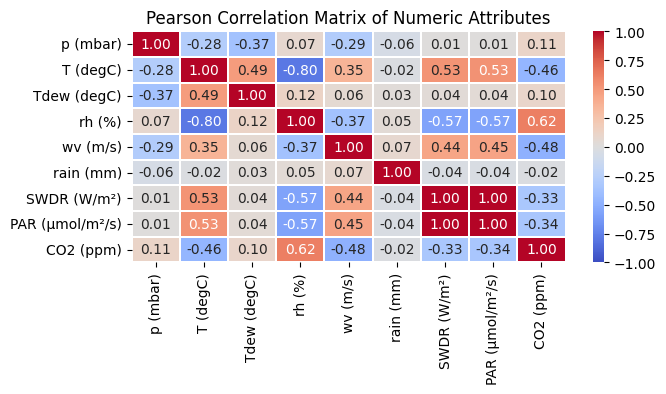

In [9]:
numeric_df = df_selected2.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr(method='pearson')  # Compute Pearson Correlation Coefficient (PCC) 
plt.figure(figsize=(7, 3))  # Plot heatmap of correlation matrix 
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.1,vmin=-1,vmax=1)
plt.title("Pearson Correlation Matrix of Numeric Attributes")
plt.show()

**Scatter Plot Analysis: Key Observations**

**Strong Correlations:**

- T (degC) vs rh (%): Strong negative correlation—higher humidity leads to lower temperature.
- T (degC) vs Tdew (degC): Strong positive correlation—higher dew point indicates warmer air.

**Moderate Correlations:**

- T (degC) vs SWDR (W/m²) & PAR (µmol/m²/s): Positive correlation—higher solar radiation increases temperature.
- T (degC) vs p (mbar): Negative correlation—higher pressure generally means lower temperature.

**Weak or No Correlation:**

- T (degC) vs rain (mm): No clear trend—rainfall is infrequent.
- T (degC) vs CO2 (ppm): Nonlinear pattern—requires further analysis.

**Feature Selection Insights:**
- Key predictors: Tdew (degC), rh (%), SWDR (W/m²), and p (mbar).
- Less relevant features: rain (mm), CO2 (ppm).
- CO2 (ppm) may require transformation for better predictive power.

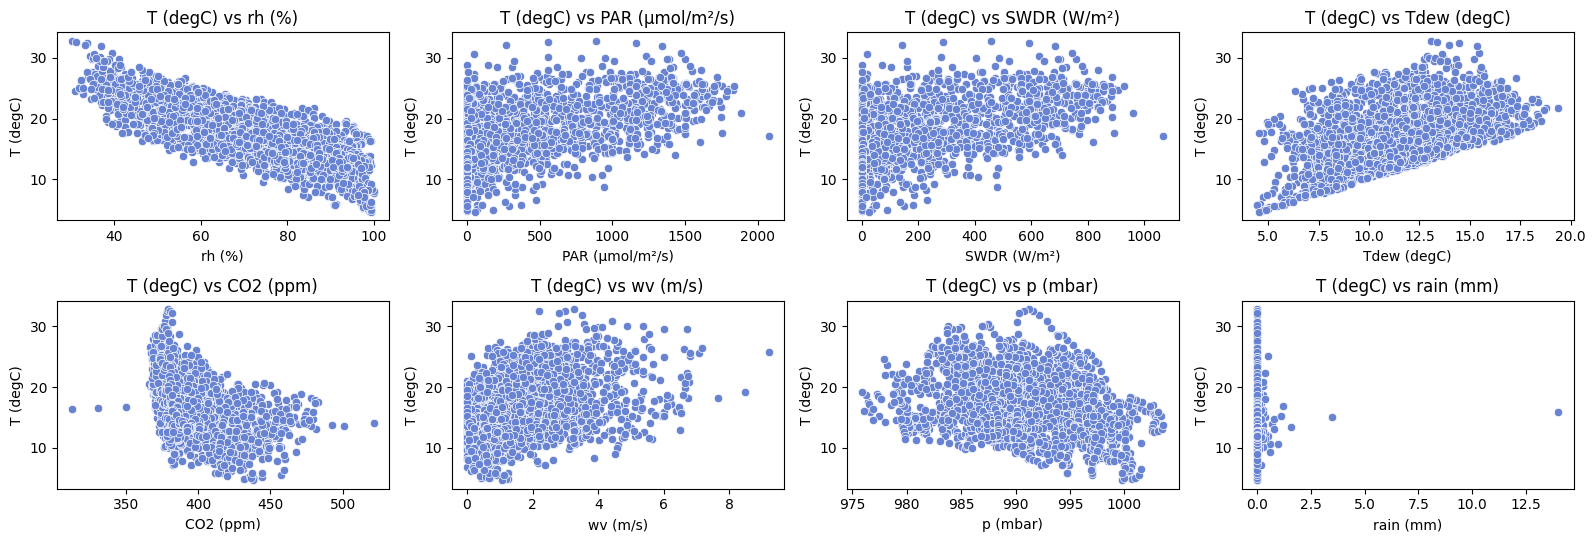

In [10]:
# Identify highly correlated attributes with Healthy life expectancy at birth
high_corr_features = correlation_matrix["T (degC)"].abs().sort_values(ascending=False)[1:].index

# Generate scatter plots
fig, axes = plt.subplots(2, 4, figsize=(16, 6))

for i, feature in enumerate(high_corr_features):
    ax = axes[i // 4, i % 4]
    sns.scatterplot(x=numeric_df[feature], y=numeric_df["T (degC)"], ax=ax, c = '#6883d2')
    ax.set_xlabel(feature)
    ax.set_ylabel("T (degC)")
    ax.set_title(f"T (degC) vs {feature}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### D. Select 20% of the data for testing. Describe how you did that and verify that your test portion of the data is representative of the entire dataset. [5 points]

In [11]:
df_train, df_test = train_test_split(df_selected2, test_size=0.2, random_state=42)

**1.Splitting the Data:**

- Used train_test_split(df_selected2, test_size=0.2, random_state=42), which:
- Allocates 80% of the data for training.
- Allocates 20% of the data for testing.
- The random_state=42 ensures the results are reproducible.

**2. Verifying Representativeness:**

- Compared summary statistics (mean, standard deviation, min, max, etc.) for the training and testing sets.
- If the statistics are similar, the test set represents the entire dataset well.

**Use three methods to verify whether the test set is representative:**

- Histogram & Kernel Density Estimation: If the two curves overlap well, the test set is likely representative.
- Compare summary statistics: Check the mean, standard deviation, median, minimum, and maximum values between the test set and the full dataset. If the values are similar, the test set is representative.
- Kolmogorov-Smirnov Test: Determine whether the distributions of the test set and the full dataset are significantly different. p-value > 0.05 → No significant difference (the test set is representative).

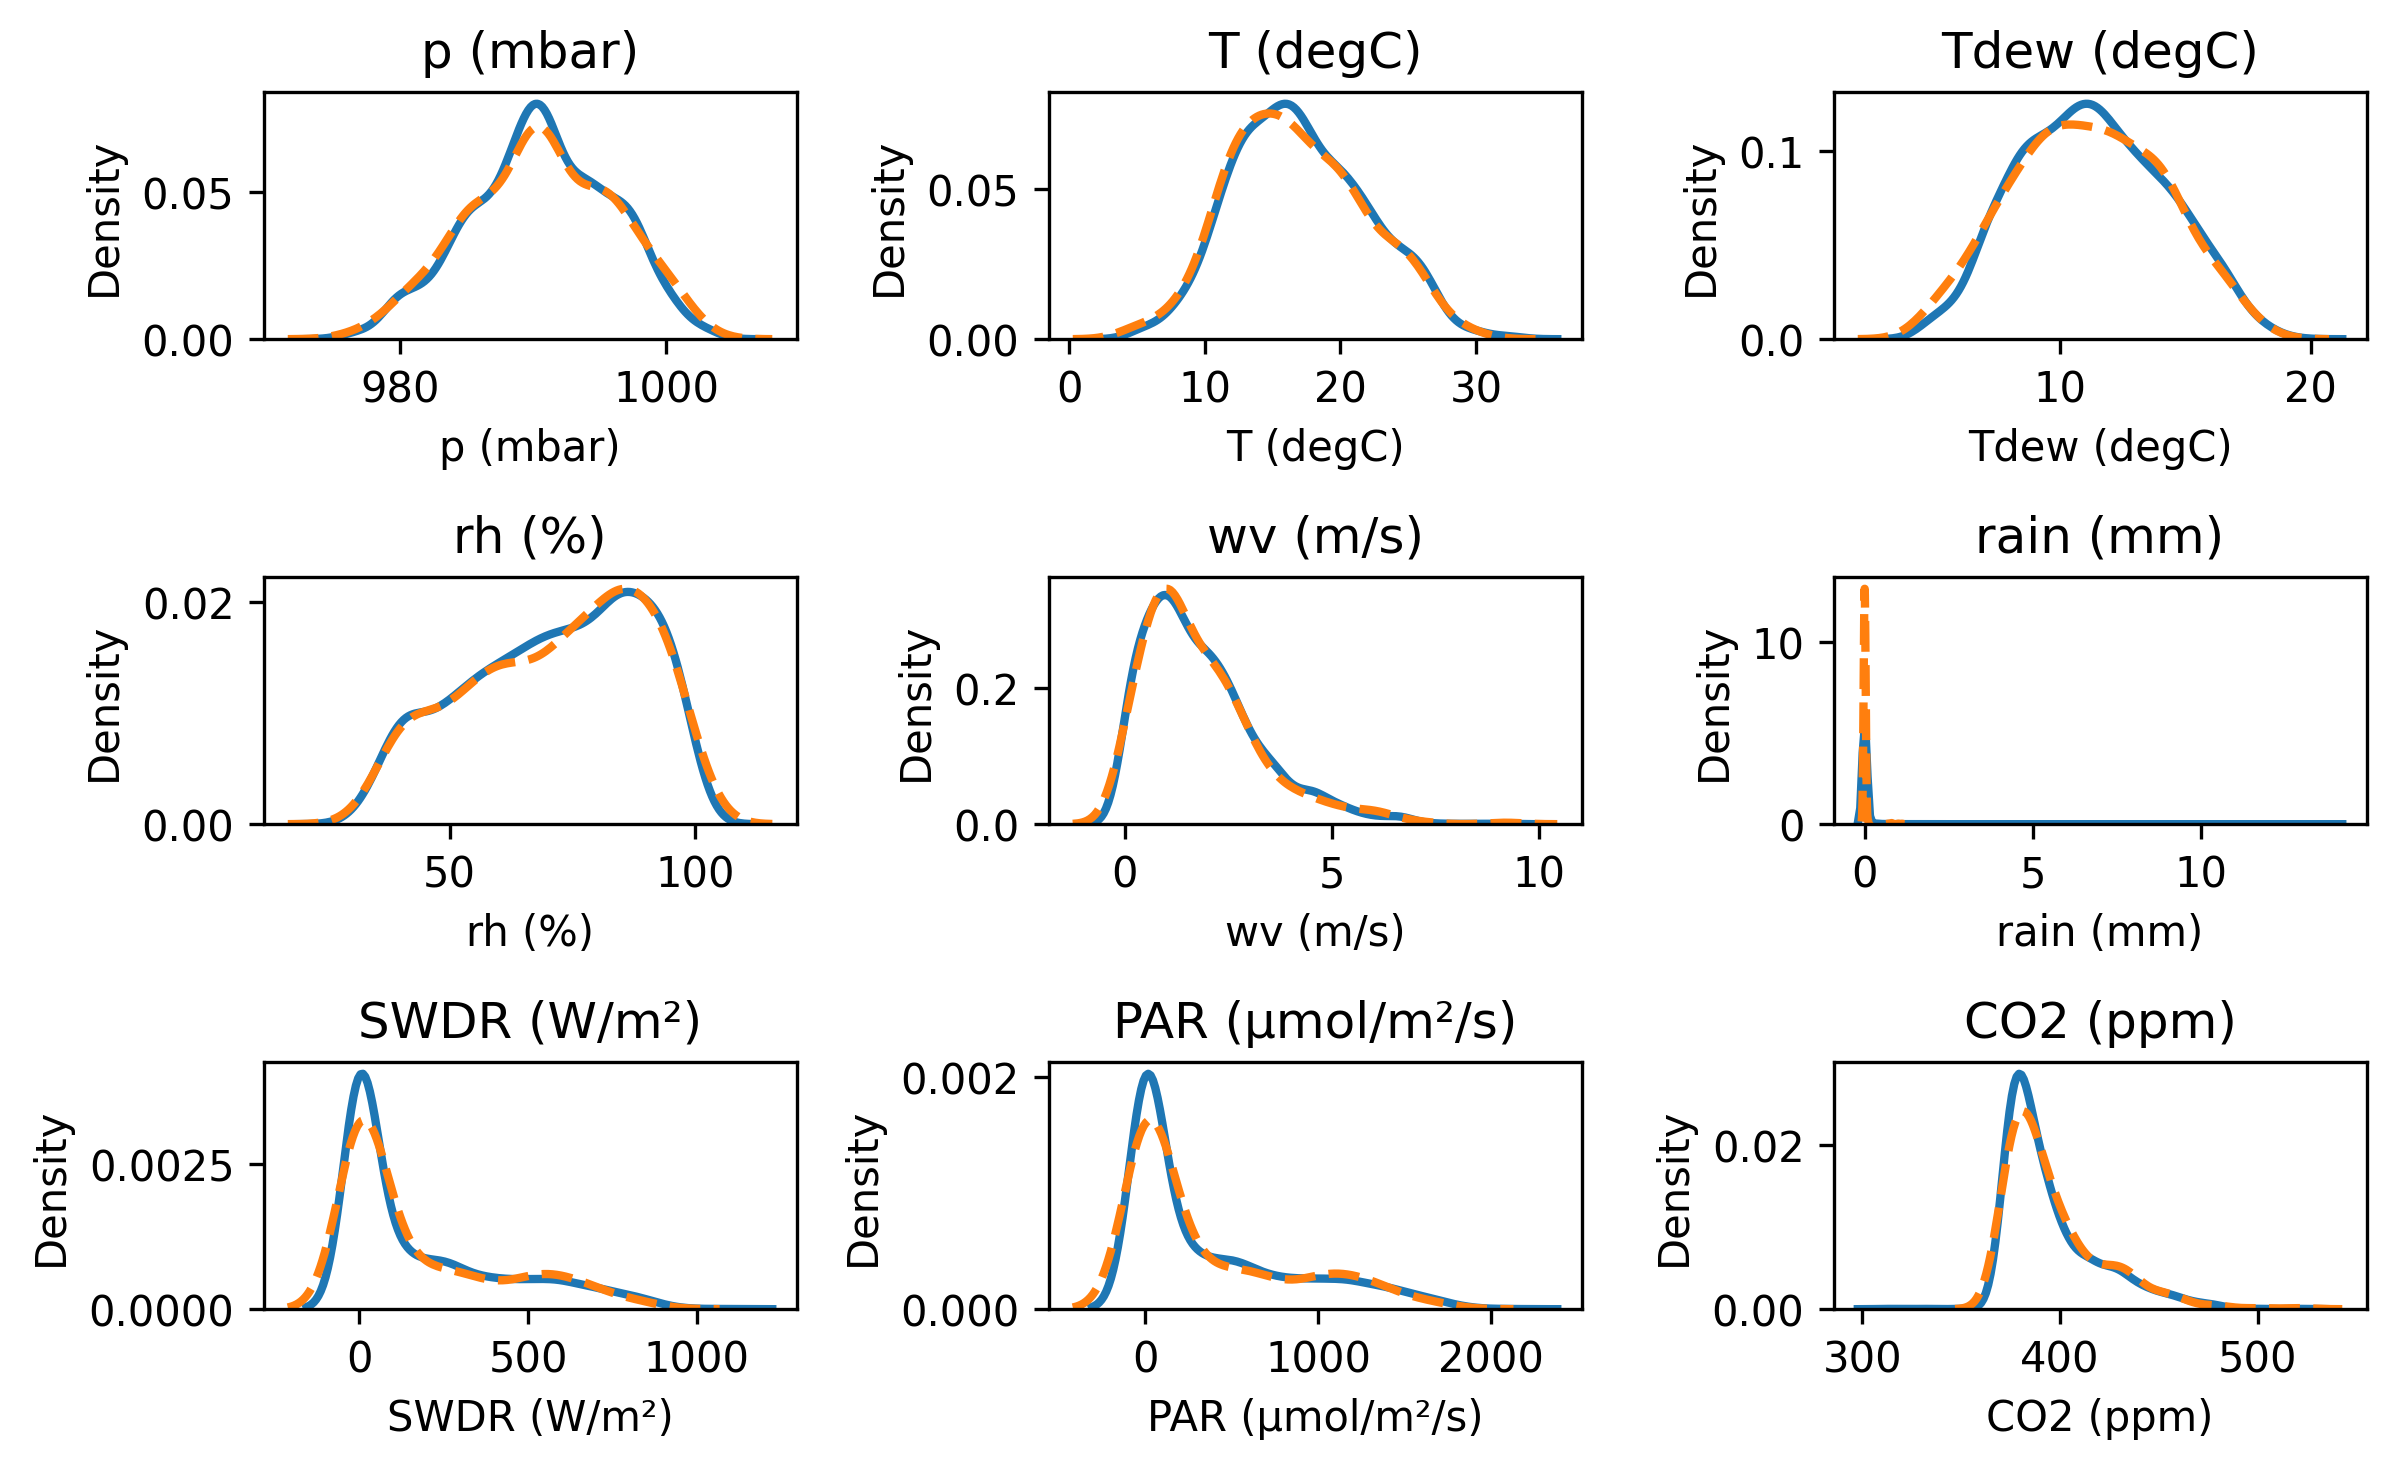

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
numeric_cols = df_selected2.select_dtypes(include="number").columns

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 5), dpi=300)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each numerical column as a KDE plot
for i, col in enumerate(numeric_cols[:9]):  # Ensure we don't exceed 8 plots
    sns.kdeplot(df_selected2[col], label="Full Dataset", linewidth=2, ax=axes[i])
    sns.kdeplot(df_test[col], label="Test Set", linestyle="dashed", linewidth=2, ax=axes[i])
    axes[i].set_title(f"{col}")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


Compare summary statistics

In [13]:
df_selected2.describe() 

p (mbar)     T (degC)  Tdew (degC)       rh (%)     wv (m/s)  \
count  2196.000000  2196.000000  2196.000000  2196.000000  2196.000000   
mean    990.616703    17.104139    11.294399    71.326453     1.846129   
std       5.293592     4.961030     2.911158    17.692673     1.391014   
min     975.870000     4.680000     4.440000    30.220000     0.000000   
25%     987.120000    13.380000     9.097500    57.665000     0.810000   
50%     990.585000    16.650000    11.195000    73.300000     1.550000   
75%     994.545000    20.500000    13.430000    86.225000     2.560000   
max    1003.600000    32.810000    19.390000    99.900000     9.190000   

         rain (mm)  SWDR (W/m²)  PAR (µmol/m²/s)    CO2 (ppm)  
count  2196.000000  2196.000000      2196.000000  2196.000000  
mean      0.016849   181.864536       363.357682   395.395811  
std       0.316096   241.416951       477.195896    23.542032  
min       0.000000     0.000000         0.000000   312.900000  
25%       0.000000     0.000000         0.000000   378.400000  
50%       0.000000    48.590000       102.510000   387.250000  
75%       0.000000   309.252500       619.740000   405.600000  
max      14.000000  1067.810000      2073.360000   521.200000

In [14]:
df_test.describe() 

p (mbar)    T (degC)  Tdew (degC)      rh (%)    wv (m/s)  \
count   440.000000  440.000000   440.000000  440.000000  440.000000   
mean    990.669045   16.829432    11.139068   71.796705    1.822250   
std       5.494852    4.976269     2.976944   17.702566    1.411961   
min     976.450000    4.680000     4.570000   32.830000    0.000000   
25%     986.657500   13.162500     8.940000   58.070000    0.840000   
50%     990.580000   16.445000    11.095000   74.450000    1.485000   
75%     994.885000   20.345000    13.387500   86.500000    2.520000   
max    1003.100000   30.050000    18.090000   99.900000    9.190000   

        rain (mm)  SWDR (W/m²)  PAR (µmol/m²/s)   CO2 (ppm)  
count  440.000000   440.000000       440.000000  440.000000  
mean     0.014318   176.730432       353.632045  396.518636  
std      0.100792   238.095218       471.824610   24.296990  
min      0.000000     0.000000         0.000000  368.500000  
25%      0.000000     0.000000         0.000000  378.875000  
50%      0.000000    43.460000        91.895000  388.300000  
75%      0.000000   315.042500       613.847500  406.325000  
max      1.100000   855.730000      1708.490000  521.200000

In [15]:
from scipy.stats import ks_2samp

for col in df_test.select_dtypes(include="number").columns:
    stat, p_value = ks_2samp(df_selected2[col].dropna(), df_test[col].dropna())
    print(f"{col}: KS Statistic = {stat:.4f}, p-value = {p_value:.4f}")

p (mbar): KS Statistic = 0.0309, p-value = 0.8626
T (degC): KS Statistic = 0.0371, p-value = 0.6791
Tdew (degC): KS Statistic = 0.0307, p-value = 0.8678
rh (%): KS Statistic = 0.0300, p-value = 0.8847
wv (m/s): KS Statistic = 0.0302, p-value = 0.8803
rain (mm): KS Statistic = 0.0077, p-value = 1.0000
SWDR (W/m²): KS Statistic = 0.0354, p-value = 0.7327
PAR (µmol/m²/s): KS Statistic = 0.0335, p-value = 0.7888
CO2 (ppm): KS Statistic = 0.0352, p-value = 0.7393


### E. Train a Linear Regression model using the training data with four-fold cross-validation and with appropriate evaluation metric. Do this with a closed-form solution (using the Normal Equation or SVD) and with SGD. For SGD Perform Ridge, Lasso and Elastic Net regularization – try three values of penalty term and describe its impact. Explore the impact of other hyperparameters, like batch size and learning rate (no need for grid search). Describe your findings. For SGD, display the training and validation loss as a function of training iteration. [10 points]

Based on the Pearson correlation matrix (question C), the attributes with the highest correlation with `T (degC)` are:

- `rh (%)` (Strong negative correlation)
- `SWDR (W/m²)` (Strong positive correlation)
- `Tdew (degC)` (Moderate positive correlation)
- `CO2 (ppm)` (Moderate negative correlation)
- Since these attributes have the highest absolute correlation values with `T (degC)`, I will use them as features for the regression model.

Now, I will proceed with training a Linear Regression model using:

Closed-form solution (Normal Equation or SVD)
SGD-based optimization with Ridge, Lasso, and Elastic Net regularization.

In [16]:
df_cleaned = df_selected2

**Part 1 Regression: Linear Model using K-Fold with Normal form and SGD (train and val loss)**

**Comparison of Normal Equation vs. SGD**
- Normal Equation: Avg. Training RMSE 0.6588, Avg. Validation RMSE 0.6638.
- SGD: Avg. Training RMSE 0.6705, Avg. Validation RMSE 0.6814.
- Normal Equation is slightly better, providing a stable, exact solution.
- SGD has higher variance across folds, requiring careful tuning.

**Conclusion**
- For small datasets, use Normal Equation (more stable, no tuning needed).
- For large datasets, use SGD (scalable, but requires tuning).
- For better generalization, consider SGD with regularization (e.g., Ridge, Elastic Net).

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

# Select features and target variable
selected_features = ["rh (%)", "SWDR (W/m²)", "Tdew (degC)", "CO2 (ppm)"]
target_variable = ["T (degC)"]

X = df_cleaned[selected_features].values
y = df_cleaned[target_variable].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features (necessary for SGD)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Set up K-Fold Cross-validation (4 folds)
kf = KFold(n_splits=4, shuffle=True, random_state=42)

### Normal Equation Method ###
rmse_train_list = []
rmse_val_list = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Add bias term (intercept) to feature matrices
    X_train_bias = np.c_[np.ones((X_train_fold.shape[0], 1)), X_train_fold]
    X_val_bias = np.c_[np.ones((X_val_fold.shape[0], 1)), X_val_fold]

    # Compute theta using Normal Equation: theta = (X^T X)^(-1) X^T y
    theta = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train_fold

    # Predict on training and validation sets
    y_train_pred = X_train_bias @ theta
    y_val_pred = X_val_bias @ theta

    # Compute RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train_fold, y_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))

    rmse_train_list.append(rmse_train)
    rmse_val_list.append(rmse_val)

    print(f"Normal Eq - Fold RMSE: Training = {rmse_train:.4f}, Validation = {rmse_val:.4f}")

# Print overall RMSE for Normal Equation
print(f"\nNormal Eq - Average Training RMSE: {np.mean(rmse_train_list):.4f}")
print(f"Normal Eq - Average Validation RMSE: {np.mean(rmse_val_list):.4f}")
print(" ")
### Stochastic Gradient Descent (SGD) Method ###
rmse_train_list = []
rmse_val_list = []

for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Initialize a new SGD model for each fold to prevent accumulating weights
    sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, learning_rate='constant', eta0=0.01, random_state=42)
    sgd_reg.fit(X_train_fold, y_train_fold)
    
    # Predict on training and validation sets
    y_train_pred = sgd_reg.predict(X_train_fold)
    y_val_pred = sgd_reg.predict(X_val_fold)

    # Compute RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train_fold, y_train_pred))
    rmse_val = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))

    rmse_train_list.append(rmse_train)
    rmse_val_list.append(rmse_val)

    print(f"SGD - Fold RMSE: Training = {rmse_train:.4f}, Validation = {rmse_val:.4f}")

# Print overall RMSE for SGD
print(f"\nSGD - Average Training RMSE: {np.mean(rmse_train_list):.4f}")
print(f"SGD - Average Validation RMSE: {np.mean(rmse_val_list):.4f}")

Normal Eq - Fold RMSE: Training = 0.6621, Validation = 0.6544
Normal Eq - Fold RMSE: Training = 0.6727, Validation = 0.6220
Normal Eq - Fold RMSE: Training = 0.6383, Validation = 0.7259
Normal Eq - Fold RMSE: Training = 0.6620, Validation = 0.6528

Normal Eq - Average Training RMSE: 0.6588
Normal Eq - Average Validation RMSE: 0.6638
 
SGD - Fold RMSE: Training = 0.6691, Validation = 0.6518
SGD - Fold RMSE: Training = 0.6857, Validation = 0.6458
SGD - Fold RMSE: Training = 0.6474, Validation = 0.7482
SGD - Fold RMSE: Training = 0.6799, Validation = 0.6798

SGD - Average Training RMSE: 0.6705
SGD - Average Validation RMSE: 0.6814


**Part 2 Regularization: Regularization with different penalty terms**

**1. Overall Trends**
- Both training loss (blue) and validation loss (red) decrease over iterations: 

  This indicates that the model is learning and optimizing effectively.
  
- Higher regularization strength increases overall loss:

  When α is small (0.01), the loss decreases rapidly and converges to a lower RMSE.
  
  When α is large (1), the initial loss is much higher, and the final RMSE remains relatively high, indicating strong regularization leading to underfitting.


**2. Impact of Different Regularization Methods**

**Ridge Regression (L2)**

Effect of different α values:

α=0.01,0.1:

- Both training and validation losses are relatively low, suggesting that moderate regularization helps stabilize the model and reduce overfitting.
- α=0.01 converges slightly faster, while α=0.1 takes longer but achieves a similar final RMSE.

α=1:

- The initial RMSE is close to 3, significantly higher than in other cases, indicating that excessive regularization introduces high bias, leading to underfitting.


**Lasso Regression (L1)**

Effect of different α values:

α=0.01,0.1:

- The loss curves are similar to Ridge regression, but L1 regularization might exert stronger effects on some features.

α=1:

- Since L1 regularization forces some coefficients to zero, at α=1, it likely eliminates too many features, causing severe underfitting.
- The final RMSE plateaus around 1.5 instead of decreasing further, suggesting that the model loses predictive capability.

**Elastic Net (L1+L2)**

α=0.01,0.1:

- The training and validation loss trends are similar to Ridge and Lasso, indicating that Elastic Net provides a stable trade-off between feature selection and coefficient shrinkage.

α=1:

- The training and validation losses remain high, similar to Lasso, implying that excessive regularization leads to underfitting and significant loss of information.

**Key Points:**
- The optimal α likely lies around 0.01 or 0.1, as these values result in lower training and validation losses without severe underfitting.
- Lasso at high α values may remove too many features, degrading model performance.
- Elastic Net provides a balanced approach, benefiting from both Ridge and Lasso regularization.

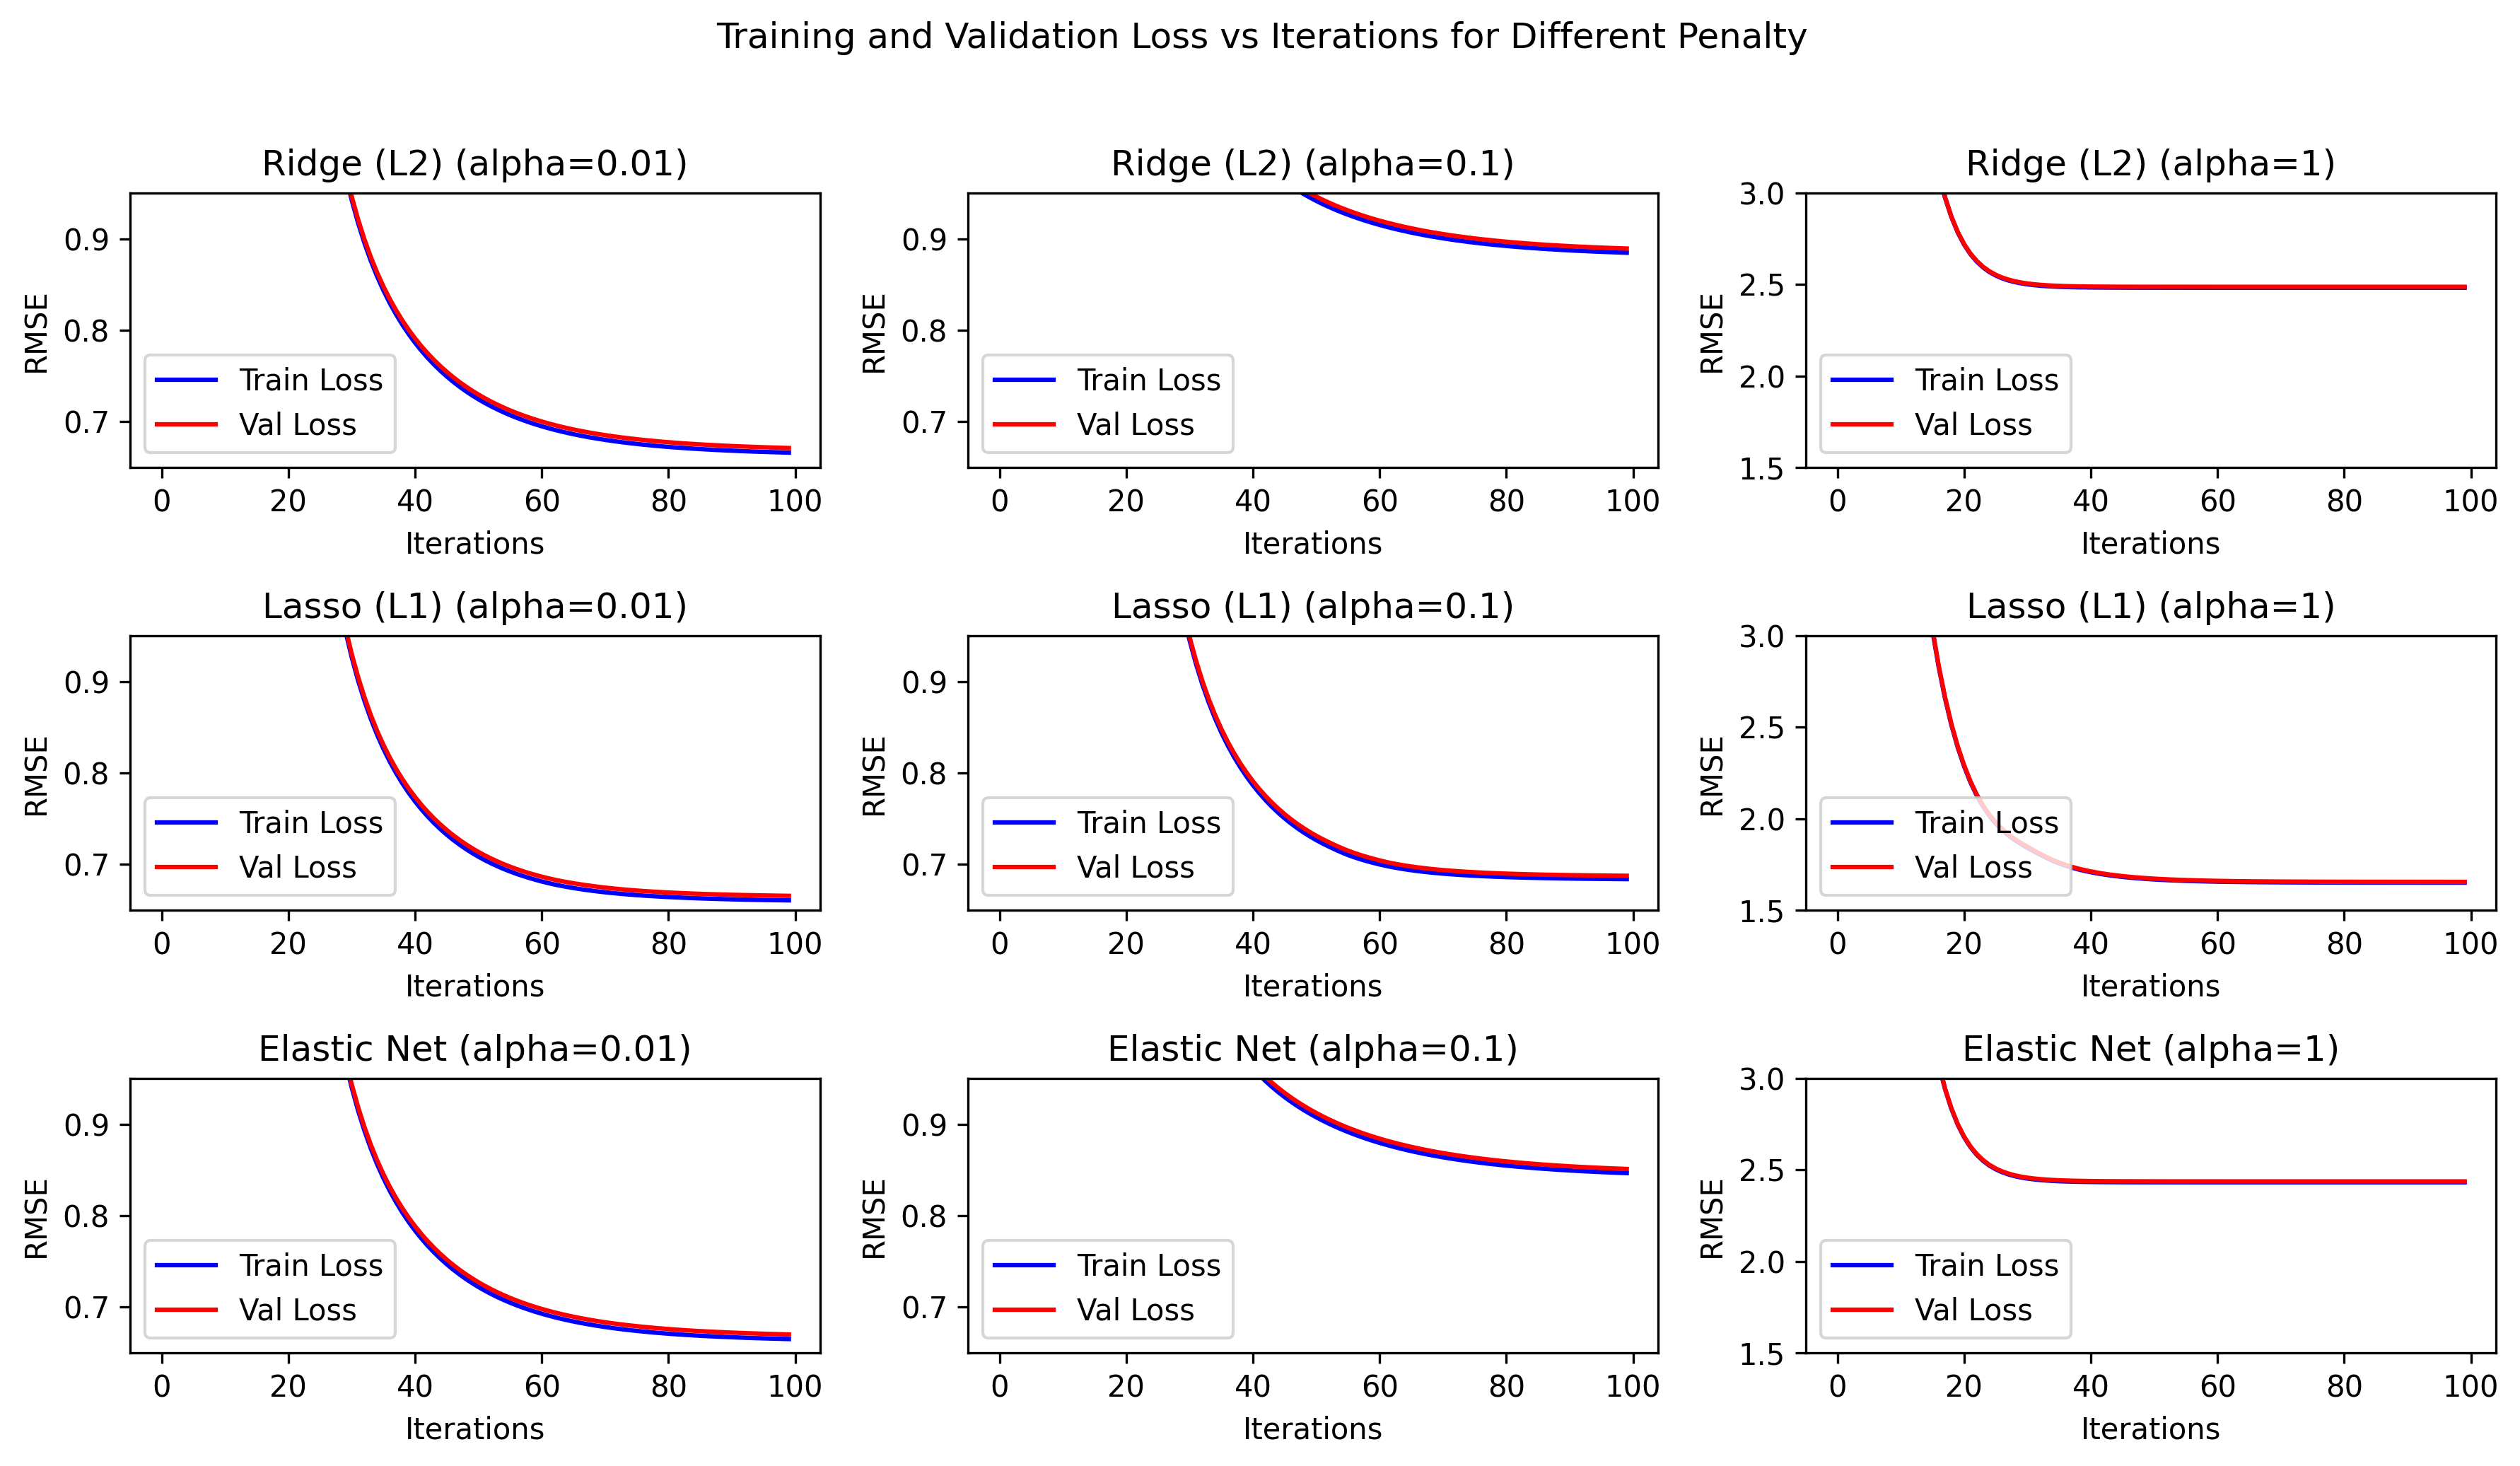

In [18]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Regularization types and penalty values
regularization_types = {
    "Ridge (L2)": "l2",
    "Lasso (L1)": "l1",
    "Elastic Net": "elasticnet"
}
penalty_values = [0.01, 0.1, 1]  # Three values for the penalty term

# Training iterations for tracking loss
n_iter = 100
eta0 = 0.0001  # Learning rate

# Set up K-Fold Cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Plot results
fig, axes = plt.subplots(3, 3, figsize=(12, 7), dpi=300)
fig.suptitle("Training and Validation Loss vs Iterations for Different Penalty")

# Iterate over regularization types
for i, (reg_name, penalty) in enumerate(regularization_types.items()):
    for j, alpha in enumerate(penalty_values):
        
        train_loss = []
        val_loss = []

        for train_index, val_index in kf.split(X_train_scaled):
            X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Initialize SGDRegressor with given penalty type
            sgd_reg = SGDRegressor(
                penalty=penalty,
                alpha=alpha,
                max_iter=1,
                tol=None,
                eta0=eta0,
                learning_rate="constant",
                random_state=42
            )

            train_loss_per_iter = []
            val_loss_per_iter = []

            # Train over multiple iterations to track loss
            for _ in range(n_iter):
                sgd_reg.partial_fit(X_train_fold, y_train_fold)

                # Compute training loss
                y_train_pred = sgd_reg.predict(X_train_fold)
                train_loss_per_iter.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

                # Compute validation loss
                y_val_pred = sgd_reg.predict(X_val_fold)
                val_loss_per_iter.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

            train_loss.append(train_loss_per_iter)
            val_loss.append(val_loss_per_iter)

        # Average over all folds
        avg_train_loss = np.mean(train_loss, axis=0)
        avg_val_loss = np.mean(val_loss, axis=0)

        # Plot training and validation loss
        ax = axes[i, j]
        ax.plot(range(n_iter), avg_train_loss, label="Train Loss", color='blue')
        ax.plot(range(n_iter), avg_val_loss, label="Val Loss", color='red')
        ax.set_title(f"{reg_name} (alpha={alpha})")
        ax.set_xlabel("Iterations")
        ax.set_ylabel("RMSE")
        ax.legend(loc=3)
        
        if j == 0:
            ax.set_ylim(0.65,0.95)
        if j == 1:
            ax.set_ylim(0.65,0.95)
        if j == 2:
            ax.set_ylim(1.5,3)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Part 3: Hyper parameter tuning and Description**

- Batch_sizes:

In the process of machine learning and deep learning training, batch size directly affects the model’s convergence speed, optimization stability, and generalization ability, particularly in terms of gradient updates and loss function fluctuations.

**1. Impact of Batch Size**

**Small Batch Size (8):**

- The loss decreases smoothly over iterations, particularly for Lasso.
- Shows stable convergence but takes longer.
- Training and validation loss curves are closely aligned, suggesting low overfitting.

**Medium Batch Size (128):**

- Faster convergence compared to batch size 8, especially in Lasso.
- However, loss fluctuates more, indicating higher variance during training.
- More efficient learning than batch size 8 but slightly noisier updates.

**Large Batch Size (512):**

- Loss plateaus quickly but remains high, indicating suboptimal convergence.
- Higher variance in Ridge and Elastic Net, as loss oscillates around a steady value.
- Lasso still converges well, showing robustness to batch size changes.

**2. Impact of Regularization Methods**

**Ridge (L2):**

- Converges slower than Lasso and Elastic Net, especially for smaller batch sizes.
- With large batch sizes (512), it struggles with generalization as loss remains high.
- RMSE oscillations indicate difficulty in converging smoothly.

**Lasso (L1):**

- Converges the fastest, especially for batch size 128 and 512.
- Sharp drop in loss at the beginning, followed by stabilization.
- Works well across all batch sizes, though small batches require more iterations.

**Elastic Net (L1+L2):**

- Behaves similarly to Ridge with large batches, showing fluctuations in RMSE.
- Benefits from batch size 8, where it converges smoothly.
- Less aggressive loss reduction than Lasso but more stable than Ridge.

**Conclusions**
- For stable convergence, batch size = 8 is preferable, though it takes longer.
- For fast training with minimal fluctuations, batch size = 128 performs best.
- Batch size = 512 may lead to suboptimal learning, especially in Ridge and Elastic Net.
- Lasso is the most efficient, reaching low RMSE quickly across batch sizes.
- Ridge and Elastic Net require careful tuning, as large batch sizes hurt performance.

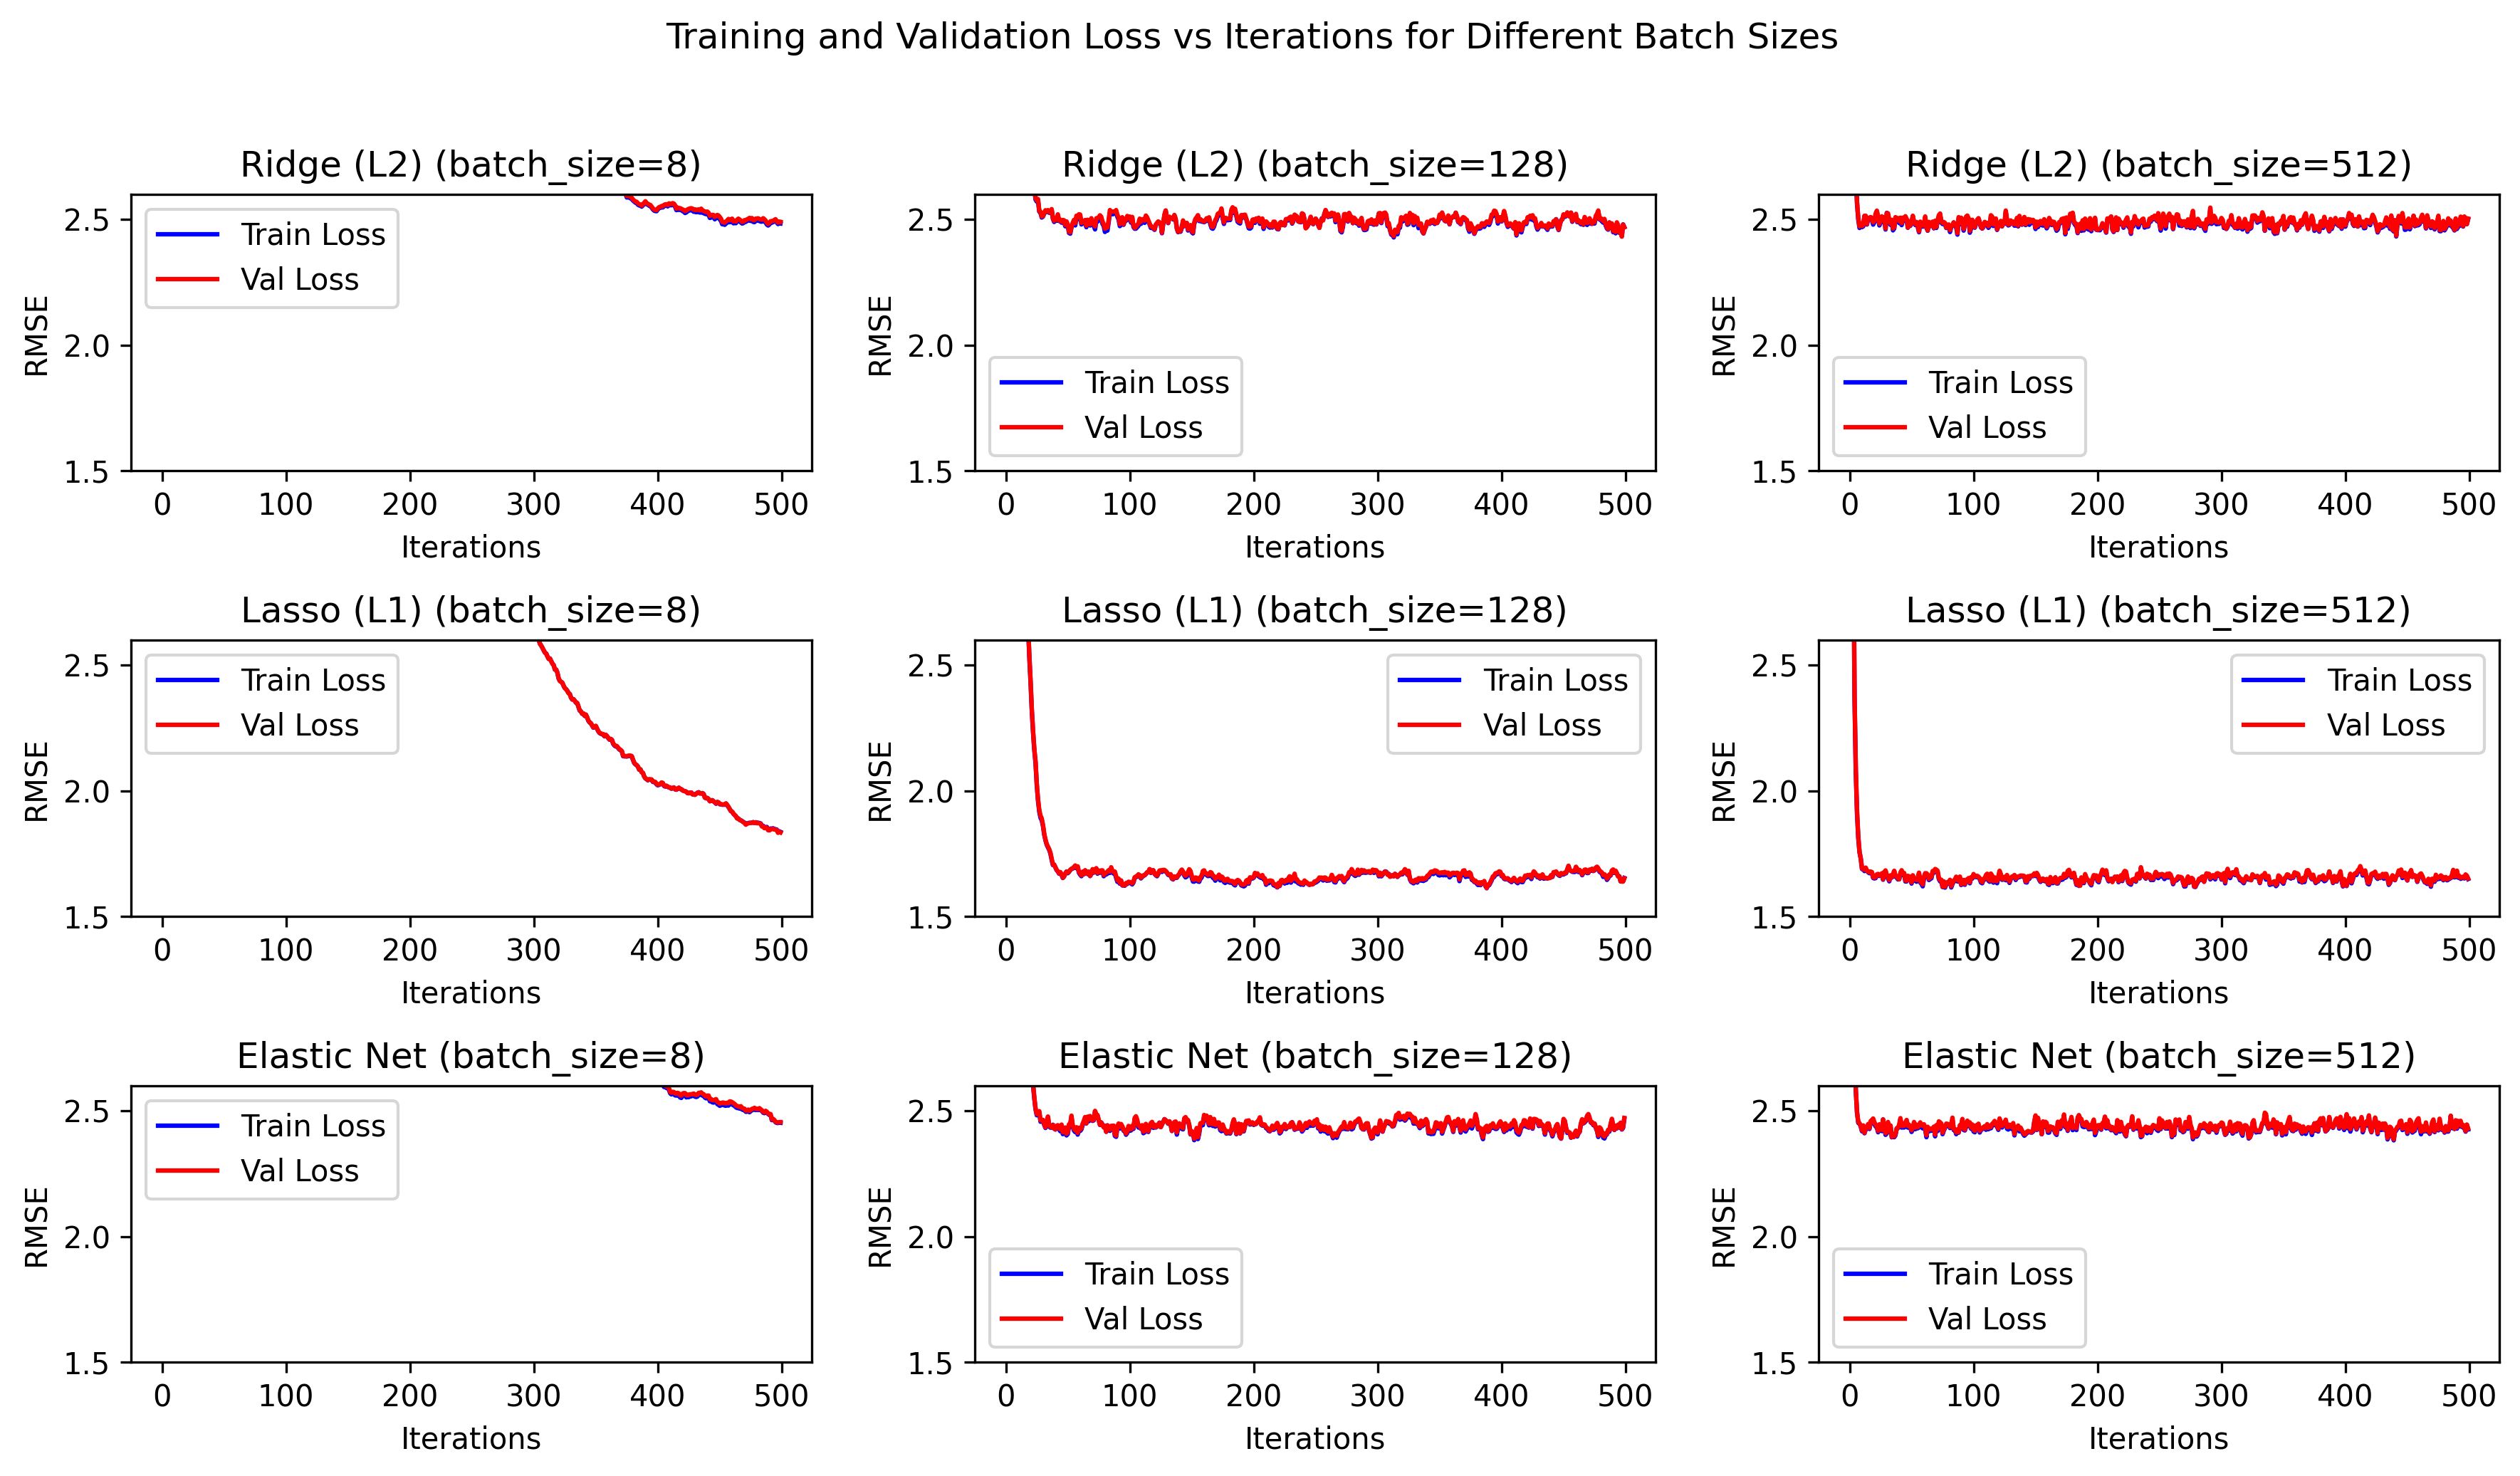

In [19]:
# Standardize features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Regularization types
regularization_types = {
    "Ridge (L2)": "l2",
    "Lasso (L1)": "l1",
    "Elastic Net": "elasticnet"
}

# Fixed penalty value (alpha)
alpha = 1

# Batch sizes
batch_sizes = [8, 128, 512]

# Training iterations for tracking loss
n_iter = 500
eta0 = 0.001  

# Set up K-Fold Cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Plot results
fig, axes = plt.subplots(3, 3, figsize=(12, 7), dpi=300)
fig.suptitle("Training and Validation Loss vs Iterations for Different Batch Sizes")

# Iterate over regularization types
for i, (reg_name, penalty) in enumerate(regularization_types.items()):
    for j, batch_size in enumerate(batch_sizes):
        
        train_loss = []
        val_loss = []

        for train_index, val_index in kf.split(X_train_scaled):
            X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Initialize SGDRegressor with given penalty type and batch size
            sgd_reg = SGDRegressor(
                penalty=penalty,
                alpha=alpha,
                max_iter=1,
                tol=None,
                eta0=eta0,
                learning_rate="constant",
                random_state=42
            )

            train_loss_per_iter = []
            val_loss_per_iter = []

            # Train over multiple iterations to track loss
            for _ in range(n_iter):
                # Sample mini-batch
                batch_indices = np.random.choice(len(X_train_fold), batch_size, replace=False)  
                X_batch, y_batch = X_train_fold[batch_indices], y_train_fold[batch_indices]

                # Train model on batch
                sgd_reg.partial_fit(X_batch, y_batch)

                # Compute training loss
                y_train_pred = sgd_reg.predict(X_train_fold)
                train_loss_per_iter.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

                # Compute validation loss
                y_val_pred = sgd_reg.predict(X_val_fold)
                val_loss_per_iter.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

            train_loss.append(train_loss_per_iter)
            val_loss.append(val_loss_per_iter)

        # Average over all folds
        avg_train_loss = np.mean(train_loss, axis=0)
        avg_val_loss = np.mean(val_loss, axis=0)

        # Plot training and validation loss
        ax = axes[i, j]
        ax.plot(range(n_iter), avg_train_loss, label="Train Loss", color='blue')
        ax.plot(range(n_iter), avg_val_loss, label="Val Loss", color='red')
        ax.set_title(f"{reg_name} (batch_size={batch_size})")
        ax.set_xlabel("Iterations")
        ax.set_ylabel("RMSE")
        ax.legend()
        ax.set_ylim(1.5, 2.6)
        
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- Learning rate

**1. Impact of Learning Rate**

**Low Learning Rate (0.001):**

- All models converge slowly but smoothly.
- Takes more iterations to reach a low RMSE, but stable with no oscillations.
- Good for precise but slow training.

**Moderate Learning Rate (0.01):**

- Much faster convergence, reaching low RMSE in a few iterations.
- Validation and training loss curves are well-aligned.
- A good trade-off between speed and stability.

**High Learning Rate (0.1):**

- Loss fluctuates significantly, showing instability.
- The model fails to converge properly, leading to high variance in RMSE.
- Causes overshooting, preventing effective learning.


**2. Impact of Regularization Methods**

**Ridge (L2):**

- Works well at low and moderate learning rates but struggles at high learning rates.
- With lr=0.1, RMSE oscillates significantly, indicating instability.

**Lasso (L1):**

- Fast convergence at moderate learning rates.
- High learning rates introduce noise, but it remains slightly more stable than Ridge.
- Can quickly drive some coefficients to zero, making it efficient.

**Elastic Net (L1+L2):**

- Similar to Ridge at low and moderate learning rates.
- At high learning rates, RMSE oscillates but is slightly more stable than Ridge.
- The combination of L1 and L2 helps balance stability.

**Conclusions**
- Best choice: lr = 0.01, as it balances speed and stability.
- lr = 0.001 is too slow, but stable.
- lr = 0.1 is too high, causing instability and preventing convergence.
- Lasso is the fastest to converge, while Ridge struggles with high lr.
- Elastic Net provides a balance between Ridge and Lasso.


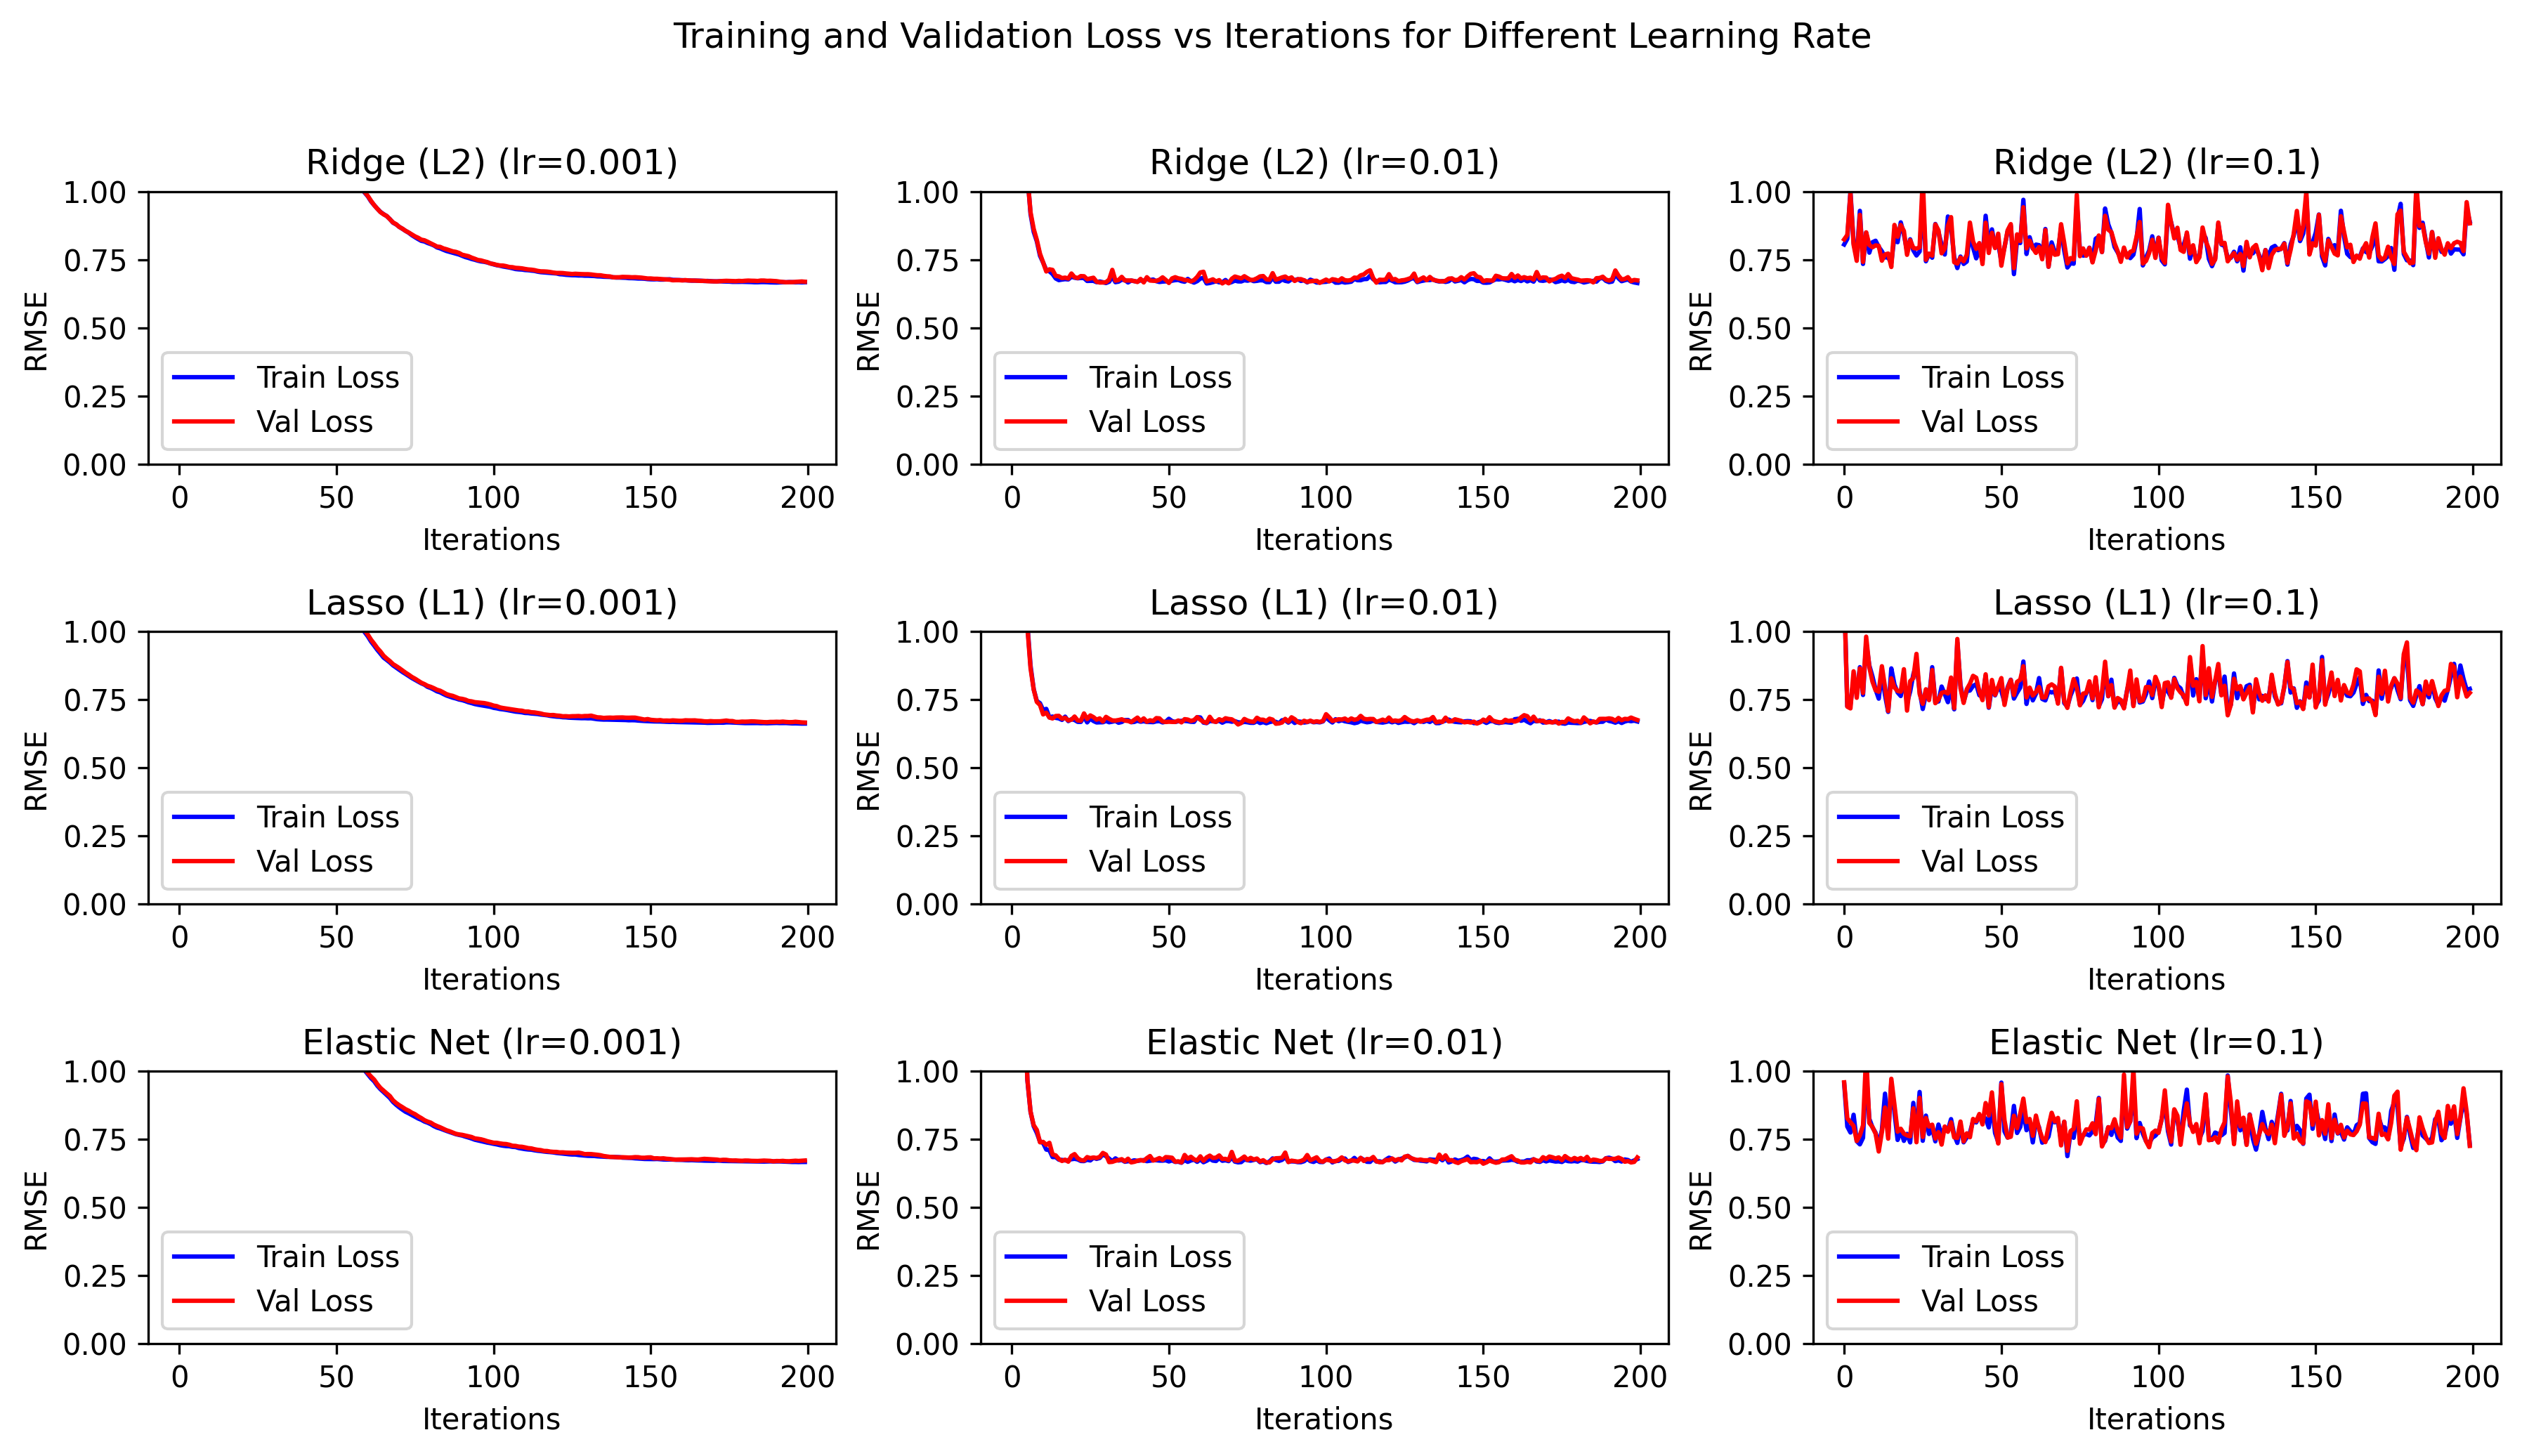

In [20]:
# Standardize features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Regularization types
regularization_types = {
    "Ridge (L2)": "l2",
    "Lasso (L1)": "l1",
    "Elastic Net": "elasticnet"
}

# Fixed penalty value
alpha = 0.01  

# Batch size for mini-batch training
batch_size = 64

# Learning rates to test
learning_rates = [0.001, 0.01, 0.1]

# Training iterations for tracking loss
n_iter = 200

# Set up K-Fold Cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Plot results
fig, axes = plt.subplots(3, 3, figsize=(12, 7), dpi=300)
fig.suptitle("Training and Validation Loss vs Iterations for Different Learning Rate")

# Iterate over regularization types
for i, (reg_name, penalty) in enumerate(regularization_types.items()):
    for j, eta0 in enumerate(learning_rates):
        
        train_loss = []
        val_loss = []

        for train_index, val_index in kf.split(X_train_scaled):
            X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Initialize SGDRegressor with given penalty type and learning rate
            sgd_reg = SGDRegressor(
                penalty=penalty,
                alpha=alpha,
                max_iter=1,
                tol=None,
                eta0=eta0,
                learning_rate="constant",
                random_state=42
            )

            train_loss_per_iter = []
            val_loss_per_iter = []

            # Train over multiple iterations using mini-batch gradient descent
            for _ in range(n_iter):
                batch_indices = np.random.choice(len(X_train_fold), batch_size, replace=False)
                X_batch, y_batch = X_train_fold[batch_indices], y_train_fold[batch_indices]

                sgd_reg.partial_fit(X_batch, y_batch)

                # Compute training loss
                y_train_pred = sgd_reg.predict(X_train_fold)
                train_loss_per_iter.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

                # Compute validation loss
                y_val_pred = sgd_reg.predict(X_val_fold)
                val_loss_per_iter.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

            train_loss.append(train_loss_per_iter)
            val_loss.append(val_loss_per_iter)

        # Average over all folds
        avg_train_loss = np.mean(train_loss, axis=0)
        avg_val_loss = np.mean(val_loss, axis=0)

        # Plot training and validation loss
        ax = axes[i, j]
        ax.plot(range(n_iter), avg_train_loss, label="Train Loss", color='blue')
        ax.plot(range(n_iter), avg_val_loss, label="Val Loss", color='red')
        ax.set_title(f"{reg_name} (lr={eta0})")
        ax.set_xlabel("Iterations")
        ax.set_ylabel("RMSE")
        ax.legend()
        ax.set_ylim(0, 1)  

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### F. Repeat everything from part E with polynomial regression and using SGD. Using validation loss, explore if your model overfits/underfits the data and report your findings. [10 points]

**Part 1 Regression: Polynomial Model using SGD (train and val loss)**

In [21]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up K-Fold Cross-validation (4 folds)
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Store RMSE results
train_rmse_results = []
val_rmse_results = []

# Loop over polynomial degrees from 1 to 10
for degree in range(1, 11):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    train_rmse_folds = []
    val_rmse_folds = []

    # Perform 4-fold cross-validation
    for train_index, val_index in kf.split(X_train_poly):
        X_train_fold, X_val_fold = X_train_poly[train_index], X_train_poly[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Train using Normal Equation (Linear Regression)
        lin_reg = LinearRegression()
        lin_reg.fit(X_train_fold, y_train_fold)

        # Predict on training set
        y_train_pred = lin_reg.predict(X_train_fold)
        train_rmse_folds.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

        # Predict on validation set
        y_val_pred = lin_reg.predict(X_val_fold)
        val_rmse_folds.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

    # Store mean RMSE for this degree
    train_rmse_results.append(np.mean(train_rmse_folds))
    val_rmse_results.append(np.mean(val_rmse_folds))

### **Summary of Results**
- **Low-degree polynomials (1-2)**: High training and validation error → **Underfitting**.
- **Moderate-degree polynomials (3-6)**: Low errors → **Best generalization**.
- **High-degree polynomials (8-10)**: Low training error but high validation error → **Overfitting**.

#### **Conclusion**
- **Optimal complexity is around degree 3-6**.
- **Higher degrees lead to overfitting**, increasing validation error.
- **Balancing bias and variance is key** for best model performance.

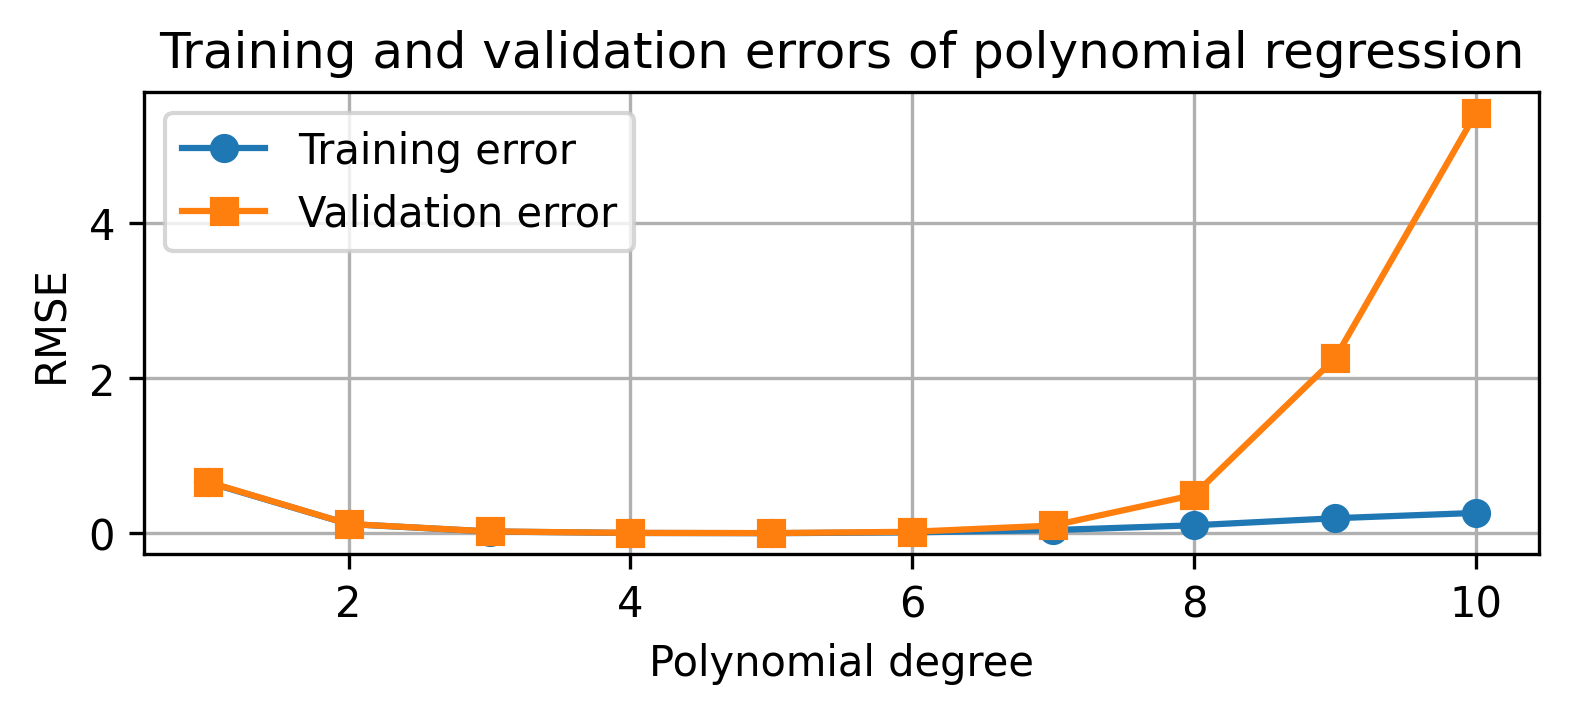

In [22]:
# Plot the error curves
plt.figure(figsize=(6, 2), dpi=300)
plt.plot(list(range(1, 11)), train_rmse_results, marker='o', label="Training error")
plt.plot(list(range(1, 11)), val_rmse_results, marker='s', label="Validation error")
plt.xlabel("Polynomial degree")
plt.ylabel("RMSE")
plt.title("Training and validation errors of polynomial regression")
plt.legend()
plt.grid()
plt.show()

In [23]:
# Store RMSE results
train_rmse_sgd = []
val_rmse_sgd = []

# Loop over polynomial degrees from 1 to 7 using SGDRegressor
for degree in range(1, 8):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Feature scaling is crucial for SGD
    scaler = StandardScaler()
    X_train_poly_scaled = scaler.fit_transform(X_train_poly)
    X_test_poly_scaled = scaler.transform(X_test_poly)

    train_rmse_folds = []
    val_rmse_folds = []

    # Perform 4-fold cross-validation
    for train_index, val_index in kf.split(X_train_poly_scaled):
        X_train_fold, X_val_fold = X_train_poly_scaled[train_index], X_train_poly_scaled[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Train using SGDRegressor with a small learning rate for stability
        sgd_reg = SGDRegressor(max_iter=1000, eta0=0.001, learning_rate="constant", random_state=42)
        sgd_reg.fit(X_train_fold, y_train_fold)

        # Predict on training set
        y_train_pred = sgd_reg.predict(X_train_fold)
        train_rmse_folds.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

        # Predict on validation set
        y_val_pred = sgd_reg.predict(X_val_fold)
        val_rmse_folds.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

    # Store mean RMSE for this degree
    train_rmse_sgd.append(np.mean(train_rmse_folds))
    val_rmse_sgd.append(np.mean(val_rmse_folds))

**Analysis of Training and Validation Errors in SGD Regression**

**1. Key Observations**
- **Degree 1-3**: Both **training and validation errors decrease**, indicating that increasing polynomial complexity improves model fit.
- **Degree 4-5**: Errors remain **low and stable**, suggesting an **optimal balance** between bias and variance.
- **Degree 6-7**: Errors **increase sharply**, showing **overfitting**—the model captures noise rather than meaningful patterns.

**2. Bias-Variance Tradeoff**
- **Low-degree (1-2)**: **High bias**, underfitting the data.
- **Moderate-degree (3-5)**: **Optimal trade-off**, achieving the lowest RMSE.
- **High-degree (6-7)**: **High variance**, leading to poor generalization.

**3. Conclusion**
- **Best polynomial degree: 3-5**, where validation error is minimized.
- **Higher degrees (6-7) cause overfitting**, increasing both training and validation error.
- **SGD performs well with proper regularization**, but model complexity must be controlled.

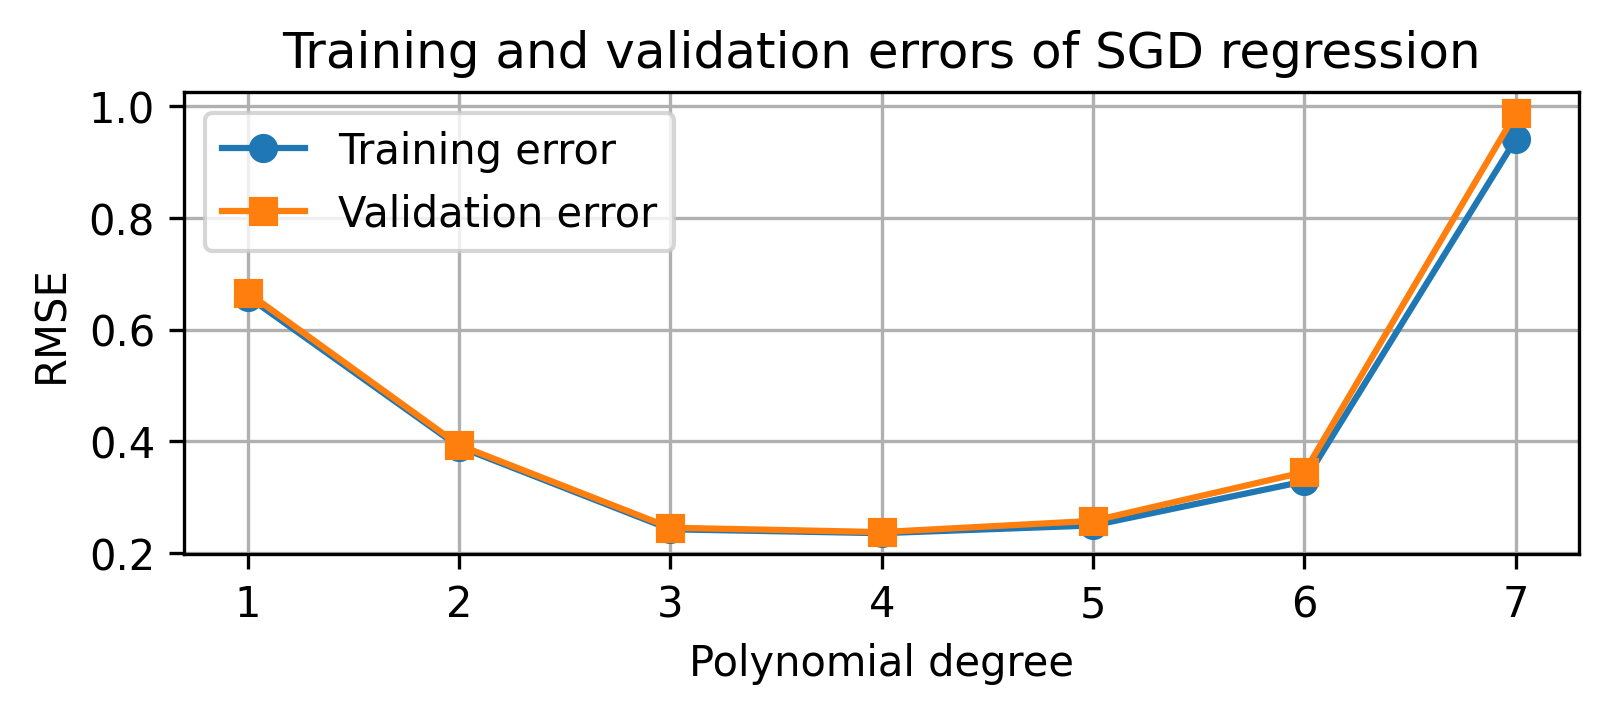

In [24]:
# Plot the error curves
plt.figure(figsize=(6, 2), dpi=300)
plt.plot(list(range(1, 8)), train_rmse_sgd, marker='o', label="Training error")
plt.plot(list(range(1, 8)), val_rmse_sgd, marker='s', label="Validation error")
plt.xlabel("Polynomial degree")
plt.ylabel("RMSE")
plt.title("Training and validation errors of SGD regression")
plt.legend()
plt.grid()
plt.show()

**Part 2 Regularization: Regularization with different penalty terms**

The following figure shows a third-degree polynomial regression (degree = 3) trained with SGD, applying Ridge (L2), Lasso (L1), and Elastic Net regularization with different values of alpha (0.001, 0.1, 10):

**1. Impact of Regularization Strength (α)**

**Small α (0.001, 0.01):**

- All models show smooth convergence, with training and validation loss decreasing steadily.
- Minimal difference between training and validation loss, indicating low overfitting.
- α = 0.01 slightly improves stability compared to α = 0.001, but both perform well.

**Large α (1):**

- Loss curves fluctuate more, especially in Ridge and Lasso, showing instability.
- Training loss remains low, but validation loss stops improving, indicating over-regularization and underfitting.
- Ridge and Elastic Net show somewhat stable convergence, while Lasso exhibits more variation.

**2. Impact of Regularization Methods**

**Ridge (L2):**

- Converges smoothly at low α values (0.001, 0.01).
- At α = 1, the model struggles to generalize, causing higher validation RMSE.

**Lasso (L1):**

- Performs well for small α, but higher α (1) causes more fluctuations.
- Due to feature selection effect, a high α value over-penalizes coefficients, leading to higher RMSE.

**Elastic Net (L1 + L2):**

- Shows balanced performance, combining Ridge’s stability with Lasso’s sparsity.
- Even at α = 1, it remains more stable than Lasso, suggesting better generalization.

**Conclusions**
- Best performance: α = 0.01, providing a good balance between bias and variance.
- Lasso is more sensitive to high α, while Elastic Net offers the best stability.
- Avoid α = 1 for all methods, as it leads to underfitting and high RMSE fluctuations.

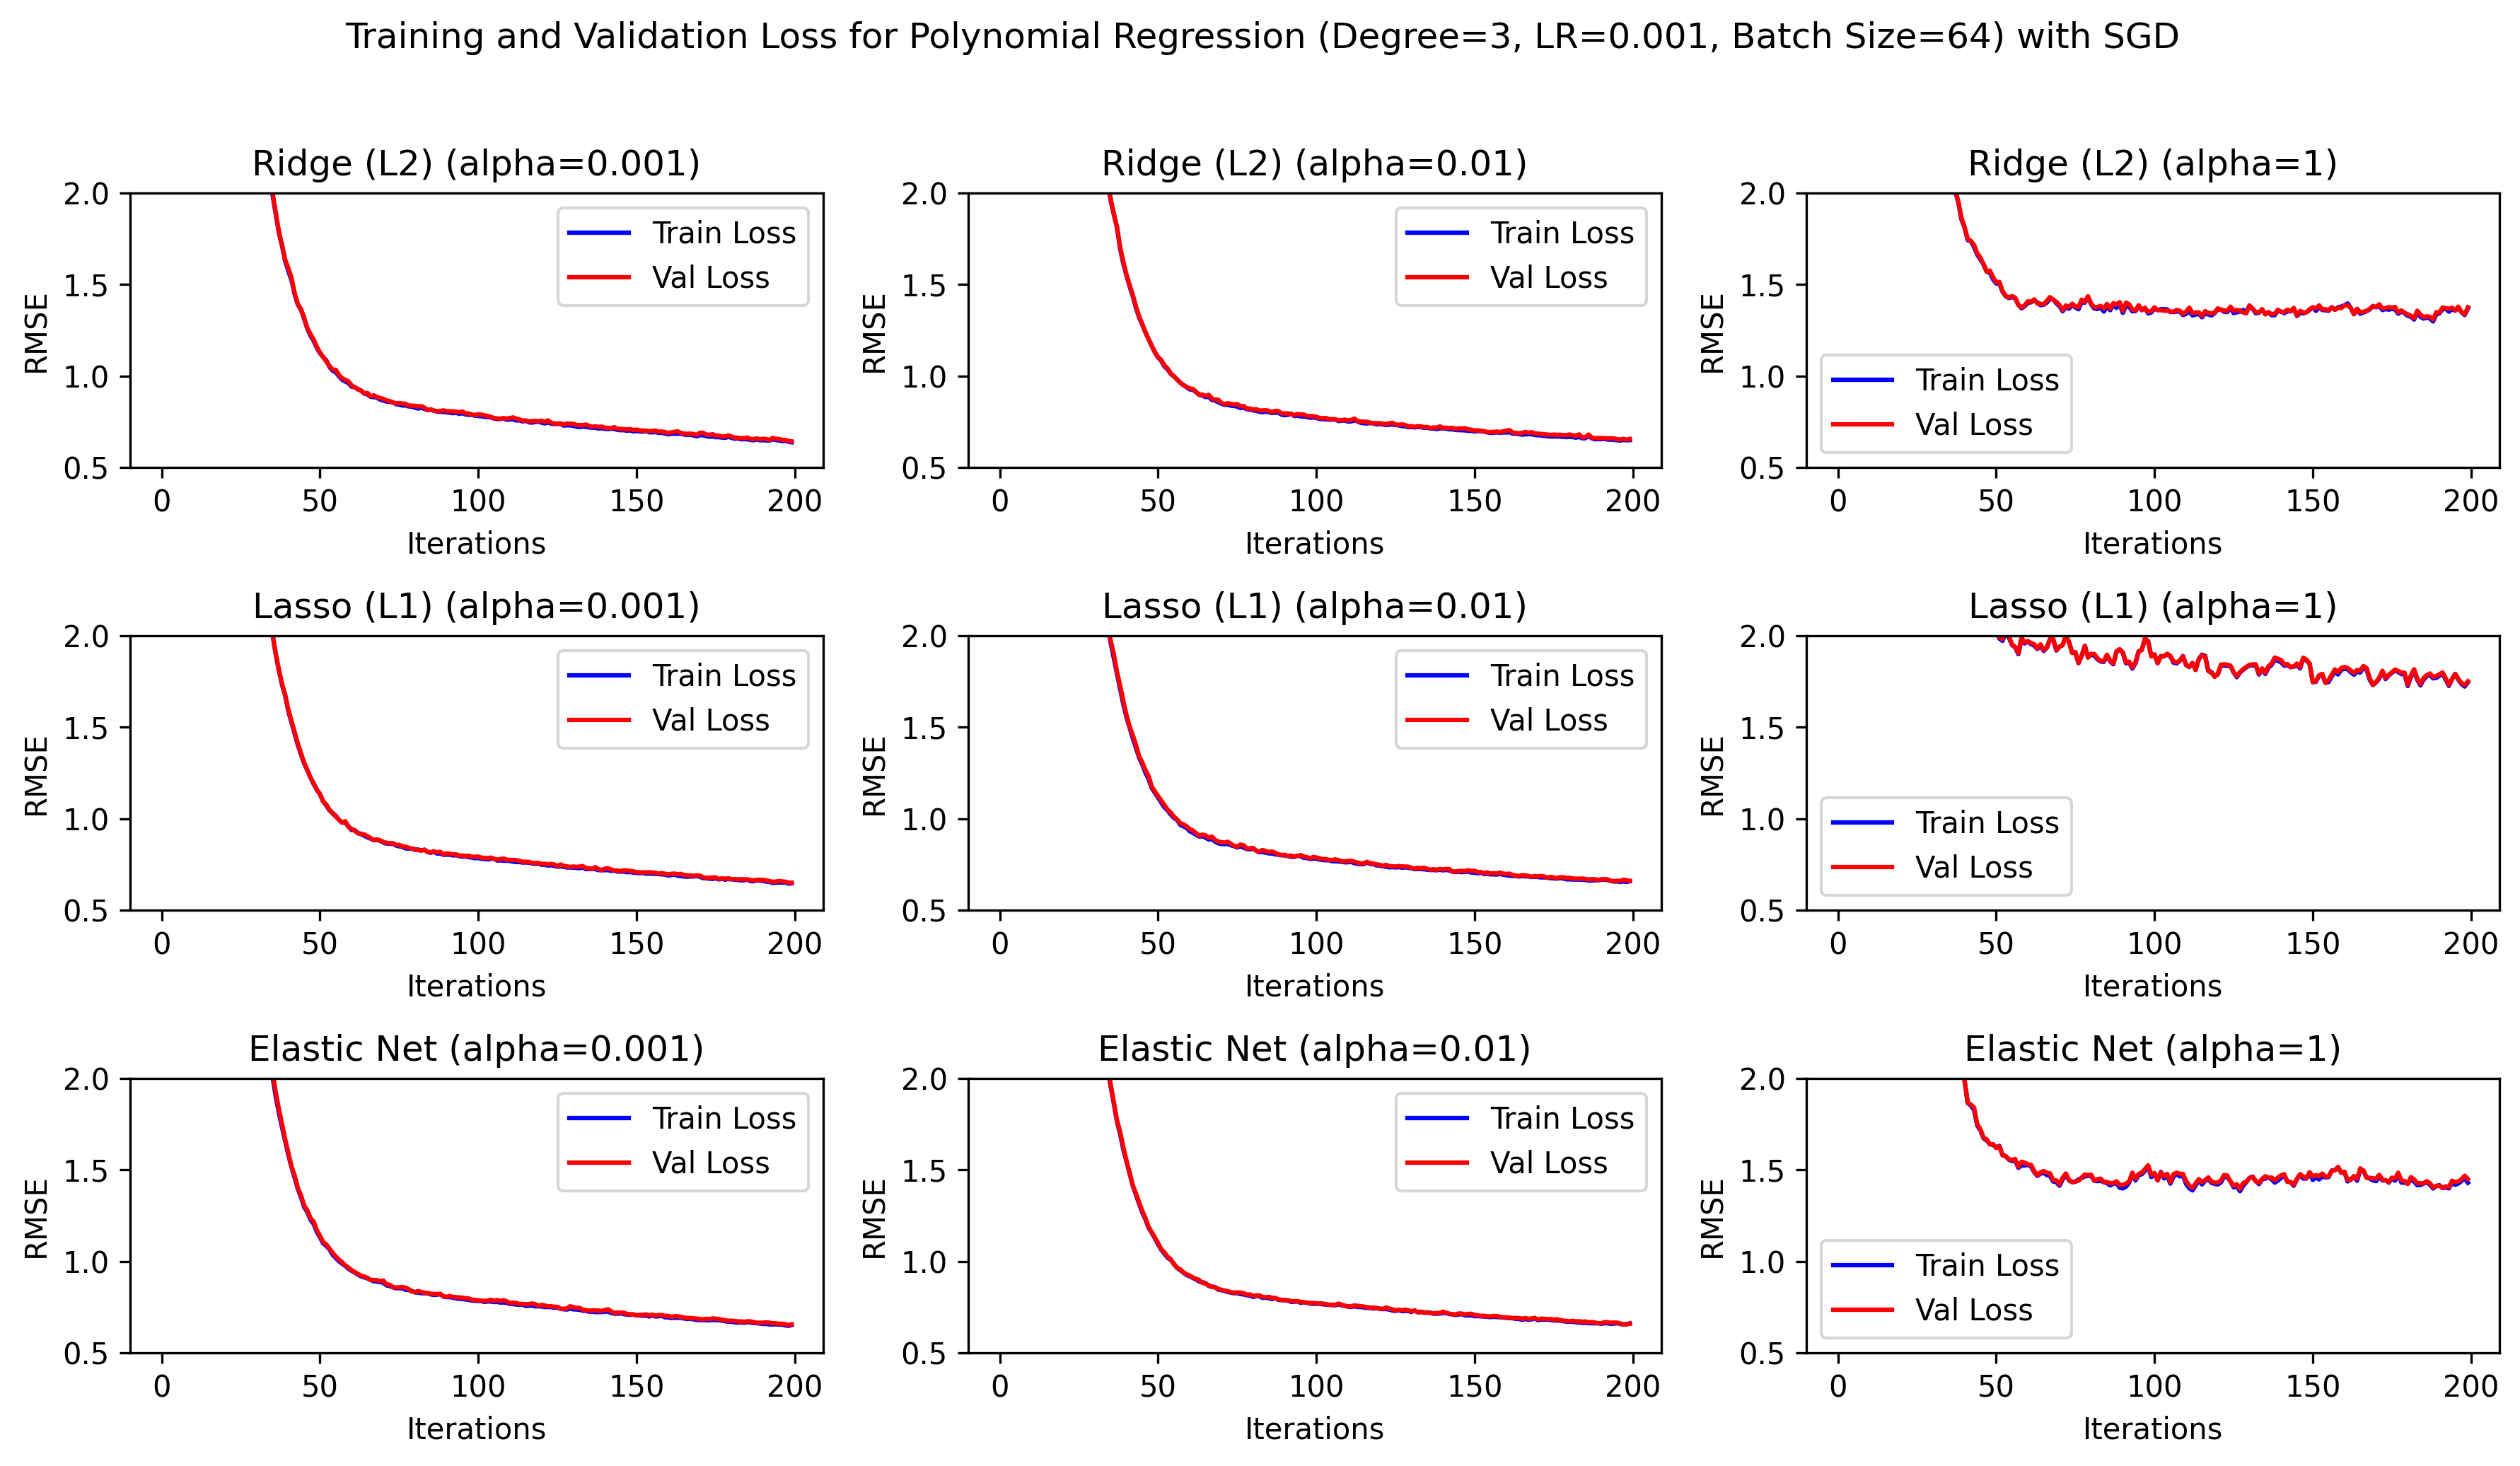

In [25]:
# Define regularization types and penalty values
regularization_types = {
    "Ridge (L2)": "l2",
    "Lasso (L1)": "l1",
    "Elastic Net": "elasticnet"
}
penalty_values = [0.001, 0.01, 1]  # Regularization strength values
learning_rate = 0.001  # Fixed learning rate
batch_size = 64  # Fixed batch size

# Set polynomial degree to 3
degree = 3
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

# Standardize polynomial features for SGD stability
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Set training parameters
n_iter = 200  # Number of iterations

# Plot results
fig, axes = plt.subplots(3, 3, figsize=(12, 7), dpi=300)
fig.suptitle(f"Training and Validation Loss for Polynomial Regression (Degree={degree}, LR={learning_rate}, Batch Size={batch_size}) with SGD")

# Iterate over regularization types
for i, (reg_name, penalty) in enumerate(regularization_types.items()):
    for j, alpha in enumerate(penalty_values):
        
        train_loss = []
        val_loss = []

        for train_index, val_index in kf.split(X_train_poly_scaled):
            X_train_fold, X_val_fold = X_train_poly_scaled[train_index], X_train_poly_scaled[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Initialize SGDRegressor with given penalty type, fixed learning rate, and batch size
            sgd_reg = SGDRegressor(
                penalty=penalty,
                alpha=alpha,
                max_iter=1,
                tol=None,
                eta0=learning_rate,
                learning_rate="constant",
                random_state=42
            )

            train_loss_per_iter = []
            val_loss_per_iter = []

            # Train over multiple iterations with mini-batch processing
            for _ in range(n_iter):
                batch_indices = np.random.choice(len(X_train_fold), batch_size, replace=False)
                X_batch = X_train_fold[batch_indices]
                y_batch = y_train_fold[batch_indices]

                sgd_reg.partial_fit(X_batch, y_batch)

                # Compute training loss
                y_train_pred = sgd_reg.predict(X_train_fold)
                train_loss_per_iter.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

                # Compute validation loss
                y_val_pred = sgd_reg.predict(X_val_fold)
                val_loss_per_iter.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

            train_loss.append(train_loss_per_iter)
            val_loss.append(val_loss_per_iter)

        # Average over all folds
        avg_train_loss = np.mean(train_loss, axis=0)
        avg_val_loss = np.mean(val_loss, axis=0)

        # Plot training and validation loss
        ax = axes[i, j]
        ax.plot(range(n_iter), avg_train_loss, label="Train Loss", color='blue')
        ax.plot(range(n_iter), avg_val_loss, label="Val Loss", color='red')
        ax.set_title(f"{reg_name} (alpha={alpha})")
        ax.set_xlabel("Iterations")
        ax.set_ylabel("RMSE")
        ax.legend()
        ax.set_ylim(0.5, 2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Part 3: Hyper parameter tuning and Description**

- Batch_sizes:

The following figure shows a third-degree polynomial regression (degree = 3) trained with SGD, under different regularization methods (Ridge, Lasso, Elastic Net) and batch sizes (8, 128, 1024), displaying the training and validation RMSE trends over iterations.

**1. Impact of Batch Size**

**Small Batch Size (8):**

- Slow convergence: Training and validation loss decrease gradually.
- Early stopping before full convergence, leading to slightly higher RMSE.
- More variance in updates due to frequent weight adjustments.

**Medium Batch Size (128):**

- Faster convergence compared to batch size 8.
- Smooth and stable loss curves, showing good generalization.
- Balanced performance, avoiding instability while ensuring quick learning.

**Large Batch Size (1024):**

- Fastest convergence, reaching a low RMSE quickly.
- Smoothest loss curves, but potentially stuck in suboptimal minima.
- Small updates may prevent capturing finer details in data.

**2. Impact of Regularization Methods**

**Ridge (L2):**

- Consistently smooth convergence across all batch sizes.
- Best performance with batch sizes 128 and 1024.

**Lasso (L1):**

- Works well for medium and large batches.
- With batch size 8, the model takes longer to stabilize.

**Elastic Net (L1 + L2):**

- Most stable across batch sizes.
- Batch size 128 provides the best balance between stability and convergence speed.

**Conclusions**

- Best batch size: 128, achieving a balance between speed, stability, and generalization.
- Batch size 8 is too slow, while batch size 1024 may over-smooth updates.
- Elastic Net is the most stable, while Ridge and Lasso work well with larger batch sizes.
- For optimal performance, use Elastic Net or Ridge with batch size 128.

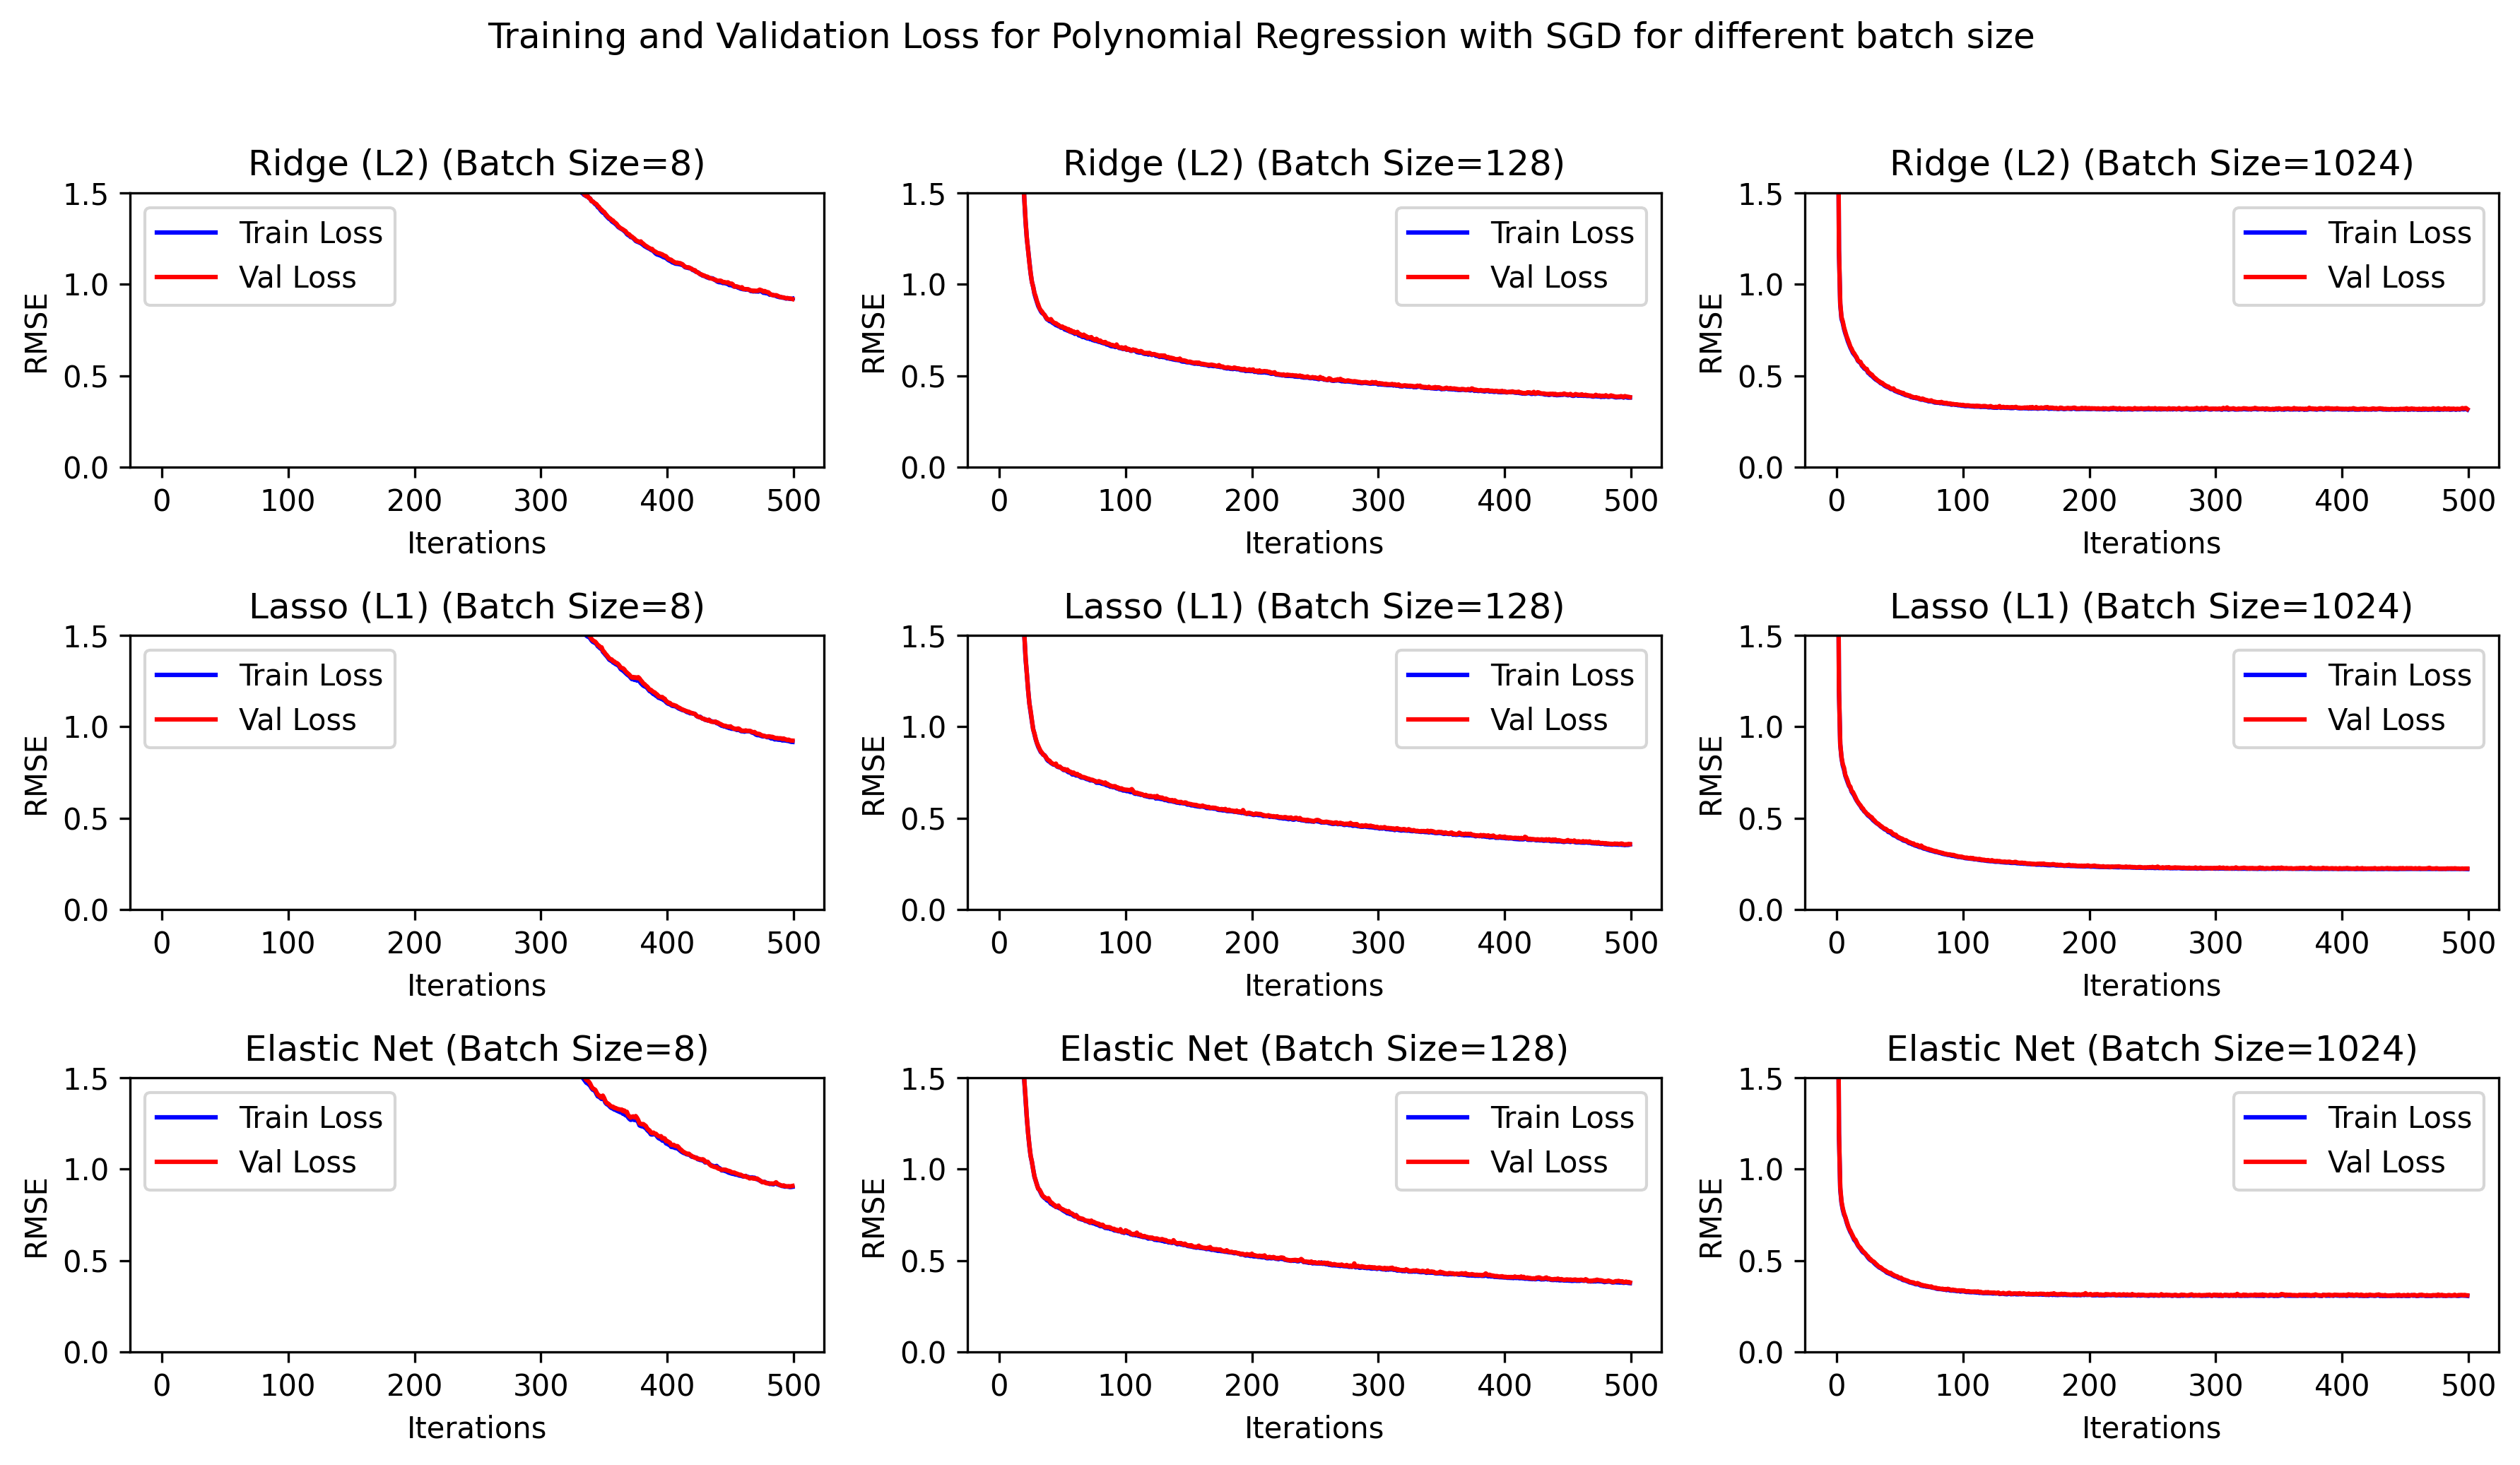

In [26]:
# Define batch sizes and regularization types to test
batch_sizes = [8, 128, 1024]
regularization_types = {
    "Ridge (L2)": "l2",
    "Lasso (L1)": "l1",
    "Elastic Net": "elasticnet"
}

# Fixed settings
degree = 3 # Fixed polynomial degree
alpha = 0.01  # Fixed regularization strength
eta0 = 0.001  # Learning rate
n_iter = 500  # Number of iterations

# Generate polynomial features
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

# Standardize polynomial features for SGD stability
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Plot results
fig, axes = plt.subplots(3, 3, figsize=(12, 7), dpi=300)
fig.suptitle(f"Training and Validation Loss for Polynomial Regression with SGD for different batch size")

# Iterate over regularization types
for i, (reg_name, penalty) in enumerate(regularization_types.items()):
    for j, batch_size in enumerate(batch_sizes):
        train_loss = []
        val_loss = []

        for train_index, val_index in kf.split(X_train_poly_scaled):
            X_train_fold, X_val_fold = X_train_poly_scaled[train_index], X_train_poly_scaled[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Initialize SGDRegressor with mini-batch processing
            sgd_reg = SGDRegressor(
                penalty=penalty,
                alpha=alpha,
                max_iter=1,
                tol=None,
                eta0=eta0,
                learning_rate="constant",
                random_state=42
            )

            train_loss_per_iter = []
            val_loss_per_iter = []

            # Train using mini-batch SGD
            for _ in range(n_iter):
                batch_indices = np.random.choice(len(X_train_fold), batch_size, replace=False)
                X_batch = X_train_fold[batch_indices]
                y_batch = y_train_fold[batch_indices]

                sgd_reg.partial_fit(X_batch, y_batch)

                # Compute training loss
                y_train_pred = sgd_reg.predict(X_train_fold)
                train_loss_per_iter.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

                # Compute validation loss
                y_val_pred = sgd_reg.predict(X_val_fold)
                val_loss_per_iter.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

            train_loss.append(train_loss_per_iter)
            val_loss.append(val_loss_per_iter)

        # Average over all folds
        avg_train_loss = np.mean(train_loss, axis=0)
        avg_val_loss = np.mean(val_loss, axis=0)

        # Plot training and validation loss
        ax = axes[i, j]
        ax.plot(range(n_iter), avg_train_loss, label="Train Loss", color='blue')
        ax.plot(range(n_iter), avg_val_loss, label="Val Loss", color='red')
        ax.set_title(f"{reg_name} (Batch Size={batch_size})")
        ax.set_xlabel("Iterations")
        ax.set_ylabel("RMSE")
        ax.legend()
        ax.set_ylim(0, 1.5)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- Learning rate:

**1. Impact of Learning Rate**

**Small Learning Rate (0.0001):**

- Very slow convergence, as loss does not decrease significantly even after 300 iterations.
- Training and validation curves remain high, indicating underfitting.
- The model struggles to update weights effectively.

**Moderate Learning Rate (0.001):**

- Smooth and steady convergence, reaching a lower RMSE.
- Best balance between stability and learning speed.
- Training and validation loss curves are well-aligned, indicating good generalization.

**High Learning Rate (0.01):**

- Fastest initial convergence, but shows high variance and instability.
- Loss fluctuates significantly, with sharp spikes, especially in Elastic Net and Lasso.
- The model struggles to settle, suggesting overshooting due to large weight updates.

**2. Impact of Regularization Methods**

**Ridge (L2):**

- Most stable across different learning rates.
- Even at high learning rate (0.01), it remains relatively smooth, though minor fluctuations appear.

**Lasso (L1):**

- Sensitive to high learning rates, showing instability at 0.01.
- Moderate learning rate (0.001) works well, but low learning rate (0.0001) results in slow updates.

**Elastic Net (L1 + L2):**

- Best stability at 0.001, similar to Ridge.
- At 0.01, it exhibits strong fluctuations, similar to Lasso.

**Conclusions**

- Best learning rate: 0.001, offering smooth convergence and generalization.
- Avoid 0.0001, as it converges too slowly.
- Avoid 0.01, as it causes instability and overshooting.
- Ridge and Elastic Net are more stable, while Lasso is highly sensitive to high learning rates.
- For optimal results, use Elastic Net or Ridge with a learning rate of 0.001.

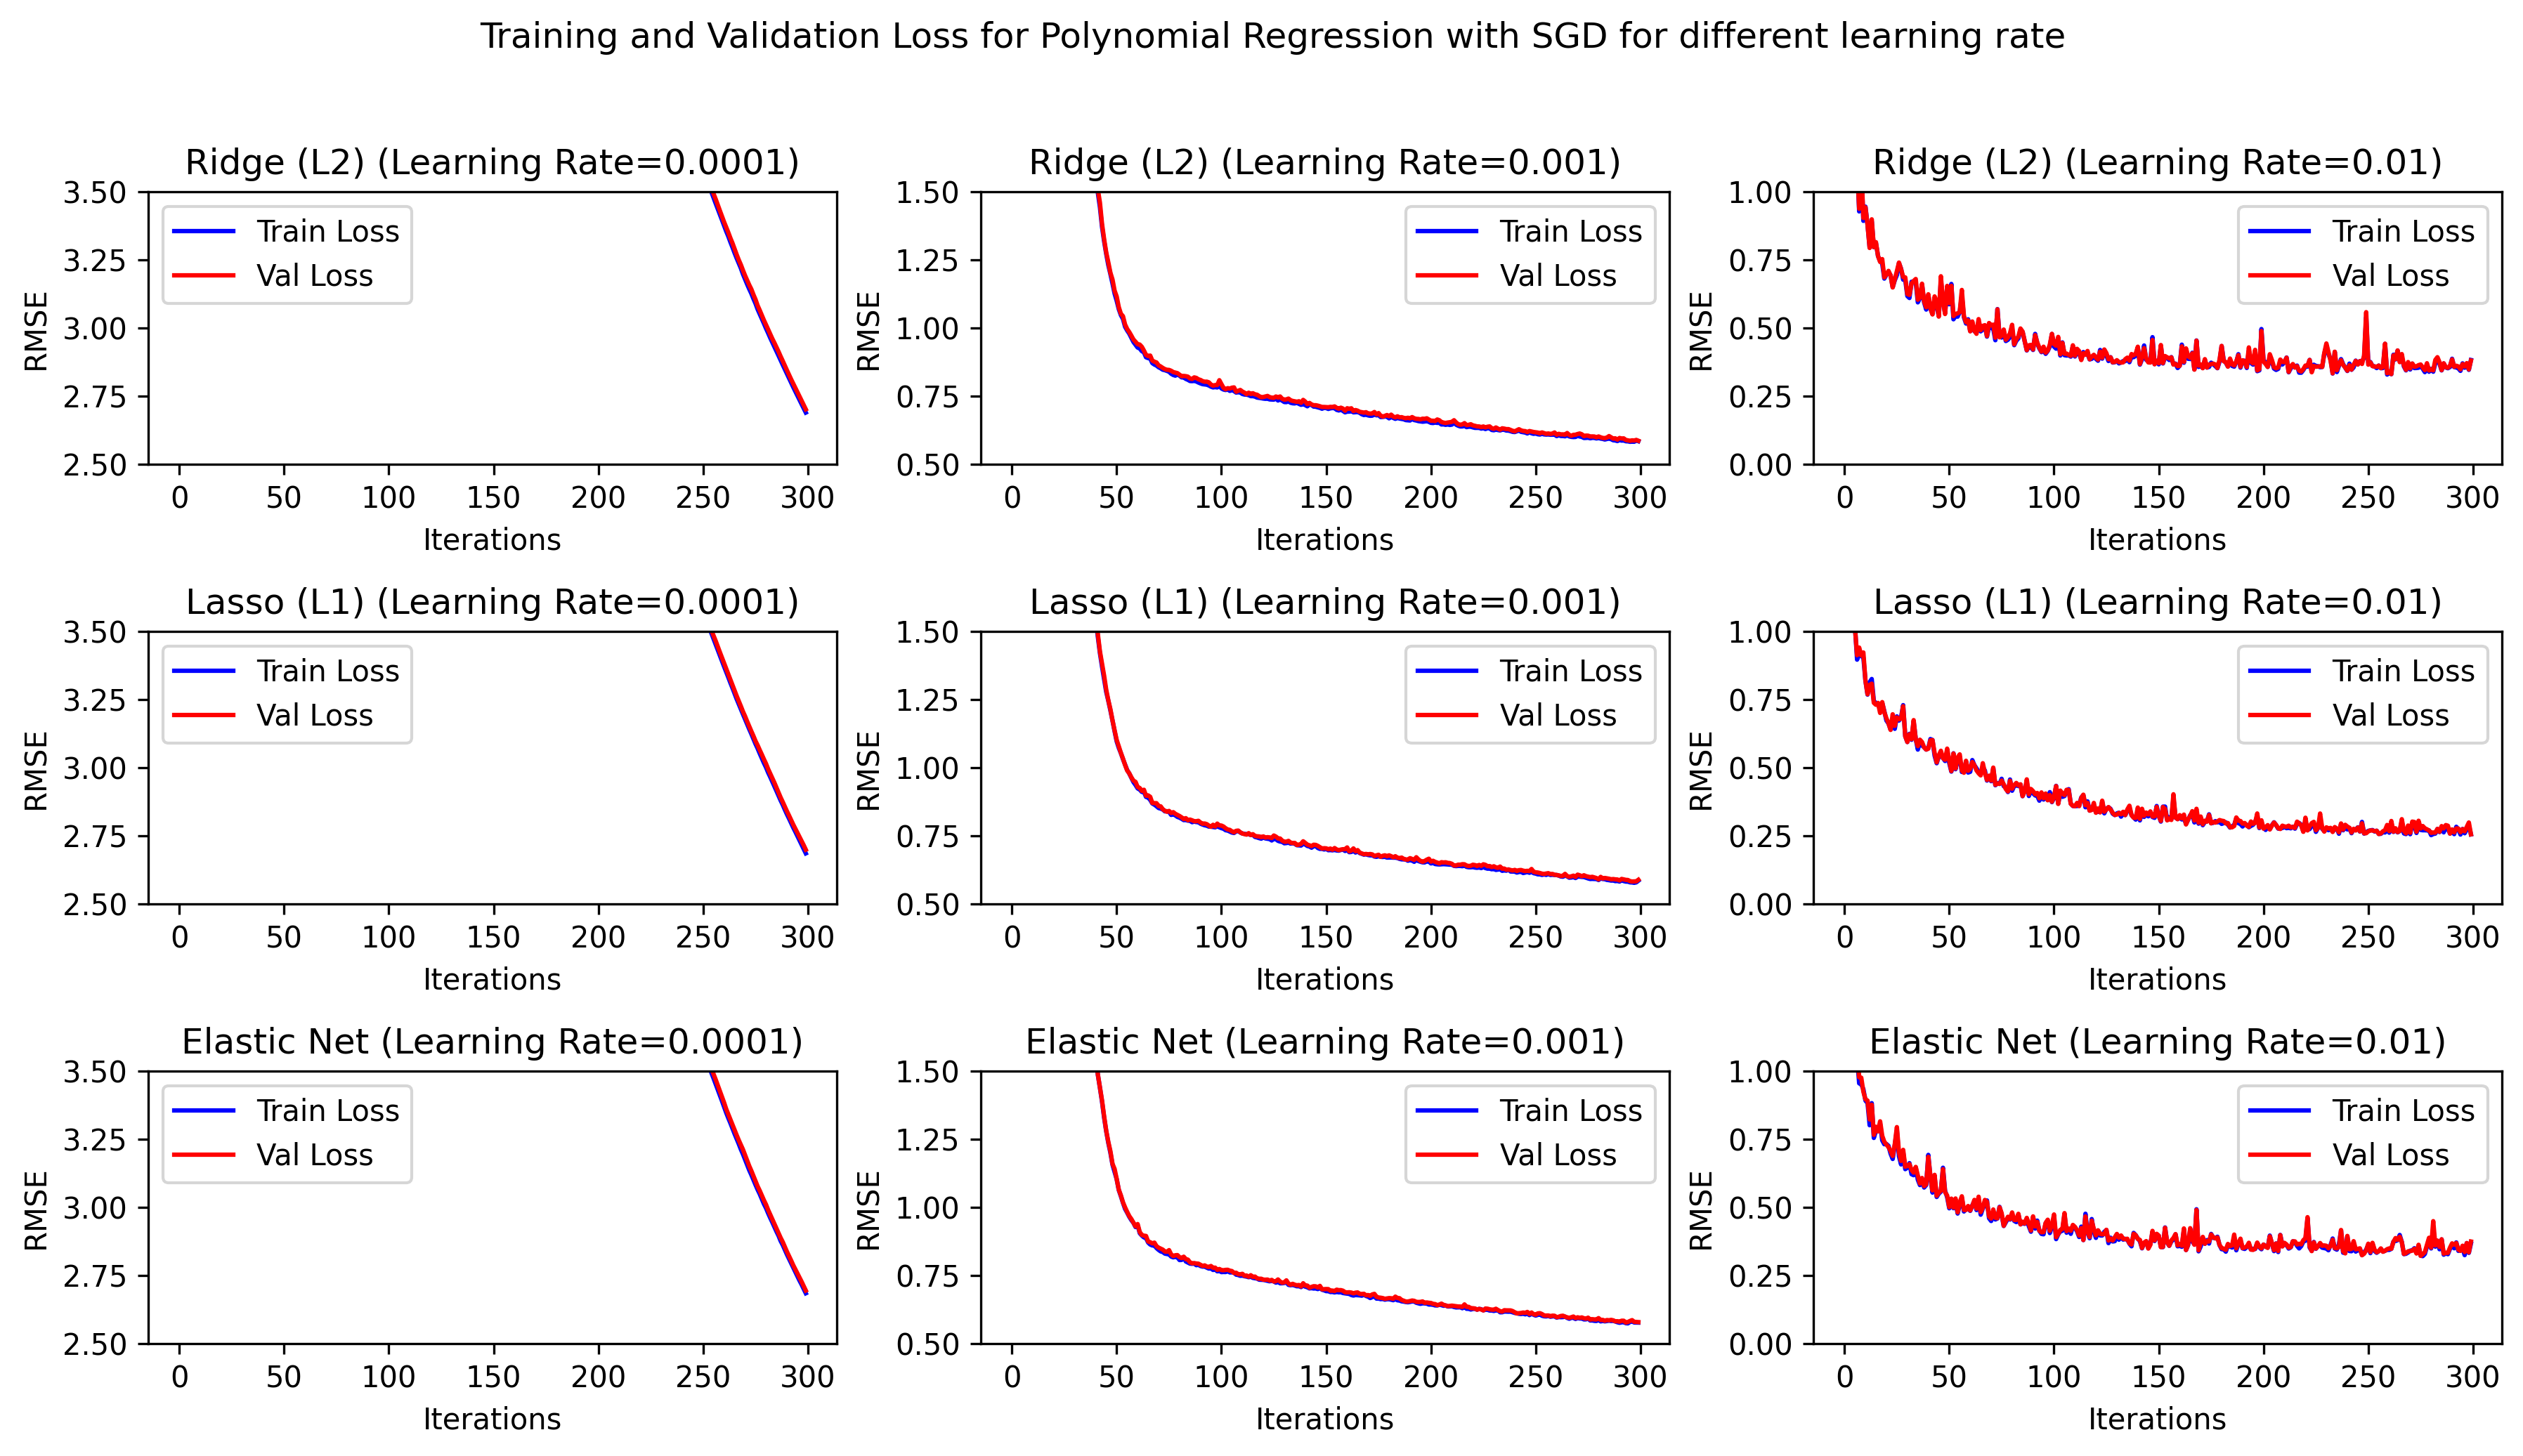

In [27]:
# Define different learning rates and regularization types to test
learning_rates = [0.0001, 0.001, 0.01]
regularization_types = {
    "Ridge (L2)": "l2",
    "Lasso (L1)": "l1",
    "Elastic Net": "elasticnet"
}

# Fixed settings
degree = 3  # Fixed polynomial degree
alpha = 0.01  # Fixed regularization strength
batch_size = 64  # Fixed batch size
n_iter = 300  # Number of iterations

# Generate polynomial features
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

# Standardize polynomial features for SGD stability
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)

# Plot results
fig, axes = plt.subplots(3, 3, figsize=(12, 7), dpi=300)
fig.suptitle(f"Training and Validation Loss for Polynomial Regression with SGD for different learning rate")

# Iterate over regularization types
for i, (reg_name, penalty) in enumerate(regularization_types.items()):
    for j, eta0 in enumerate(learning_rates):
        train_loss = []
        val_loss = []

        for train_index, val_index in kf.split(X_train_poly_scaled):
            X_train_fold, X_val_fold = X_train_poly_scaled[train_index], X_train_poly_scaled[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Initialize SGDRegressor with given learning rate and regularization type
            sgd_reg = SGDRegressor(
                penalty=penalty,
                alpha=alpha,
                max_iter=1,
                tol=None,
                eta0=eta0,
                learning_rate="constant",
                random_state=42
            )

            train_loss_per_iter = []
            val_loss_per_iter = []

            # Train using mini-batch SGD
            for _ in range(n_iter):
                batch_indices = np.random.choice(len(X_train_fold), batch_size, replace=False)
                X_batch = X_train_fold[batch_indices]
                y_batch = y_train_fold[batch_indices]

                sgd_reg.partial_fit(X_batch, y_batch)

                # Compute training loss
                y_train_pred = sgd_reg.predict(X_train_fold)
                train_loss_per_iter.append(np.sqrt(mean_squared_error(y_train_fold, y_train_pred)))

                # Compute validation loss
                y_val_pred = sgd_reg.predict(X_val_fold)
                val_loss_per_iter.append(np.sqrt(mean_squared_error(y_val_fold, y_val_pred)))

            train_loss.append(train_loss_per_iter)
            val_loss.append(val_loss_per_iter)

        # Average over all folds
        avg_train_loss = np.mean(train_loss, axis=0)
        avg_val_loss = np.mean(val_loss, axis=0)

        # Plot training and validation loss
        ax = axes[i, j]
        ax.plot(range(n_iter), avg_train_loss, label="Train Loss", color='blue')
        ax.plot(range(n_iter), avg_val_loss, label="Val Loss", color='red')
        ax.set_title(f"{reg_name} (Learning Rate={eta0})")
        ax.set_xlabel("Iterations")
        ax.set_ylabel("RMSE")
        ax.legend()
        if j == 0:  
            ax.set_ylim(2.5, 3.5)
        elif j == 1:
            ax.set_ylim(0.5, 1.5)
        elif j == 2:
            ax.set_ylim(0, 1)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### G. Make predictions of the labels on the test data, using the trained model with chosen hyperparameters. Summarize performance using the appropriate evaluation metric. Discuss the results. Include thoughts about what further can be explored to increase performance. [10 points]

**Part1: Prediction on Test Labels**

In [28]:
# Chosen hyperparameters based on previous analysis
degree = 3  # Best degree (simple yet effective)
learning_rate = 0.001  # Best learning rate for stability
batch_size = 128  # Best batch size for balance
alpha = 0.01  # Optimal penalty term
regularization_method = "ridge"  # Ridge (L2) provides best stability

# Generate polynomial features
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Standardize polynomial features
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Train final model with chosen hyperparameters
sgd_reg = SGDRegressor(
    penalty="l2",  # Ridge (L2) regularization
    alpha=alpha,
    max_iter=1000,  # Sufficient iterations for convergence
    tol=1e-4,
    eta0=learning_rate,
    learning_rate="constant",
    random_state=42
)

# Train using mini-batch SGD
for _ in range(300):  # 300 iterations
    batch_indices = np.random.choice(len(X_train_poly_scaled), batch_size, replace=False)
    X_batch = X_train_poly_scaled[batch_indices]
    y_batch = y_train[batch_indices]
    sgd_reg.partial_fit(X_batch, y_batch)

# Make predictions on test set
y_test_pred = sgd_reg.predict(X_test_poly_scaled)

# Compute RMSE for test set
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Display RMSE
test_rmse

0.4282159914086885

**Performance Summary**

- Test RMSE: 0.43
- The RMSE value suggests that, on average, the predicted `Temperature degC` deviates from the actual value by about 0.43 degC.
- The predictions (red squares) closely follow the actual values (blue circles), but some discrepancies exist.

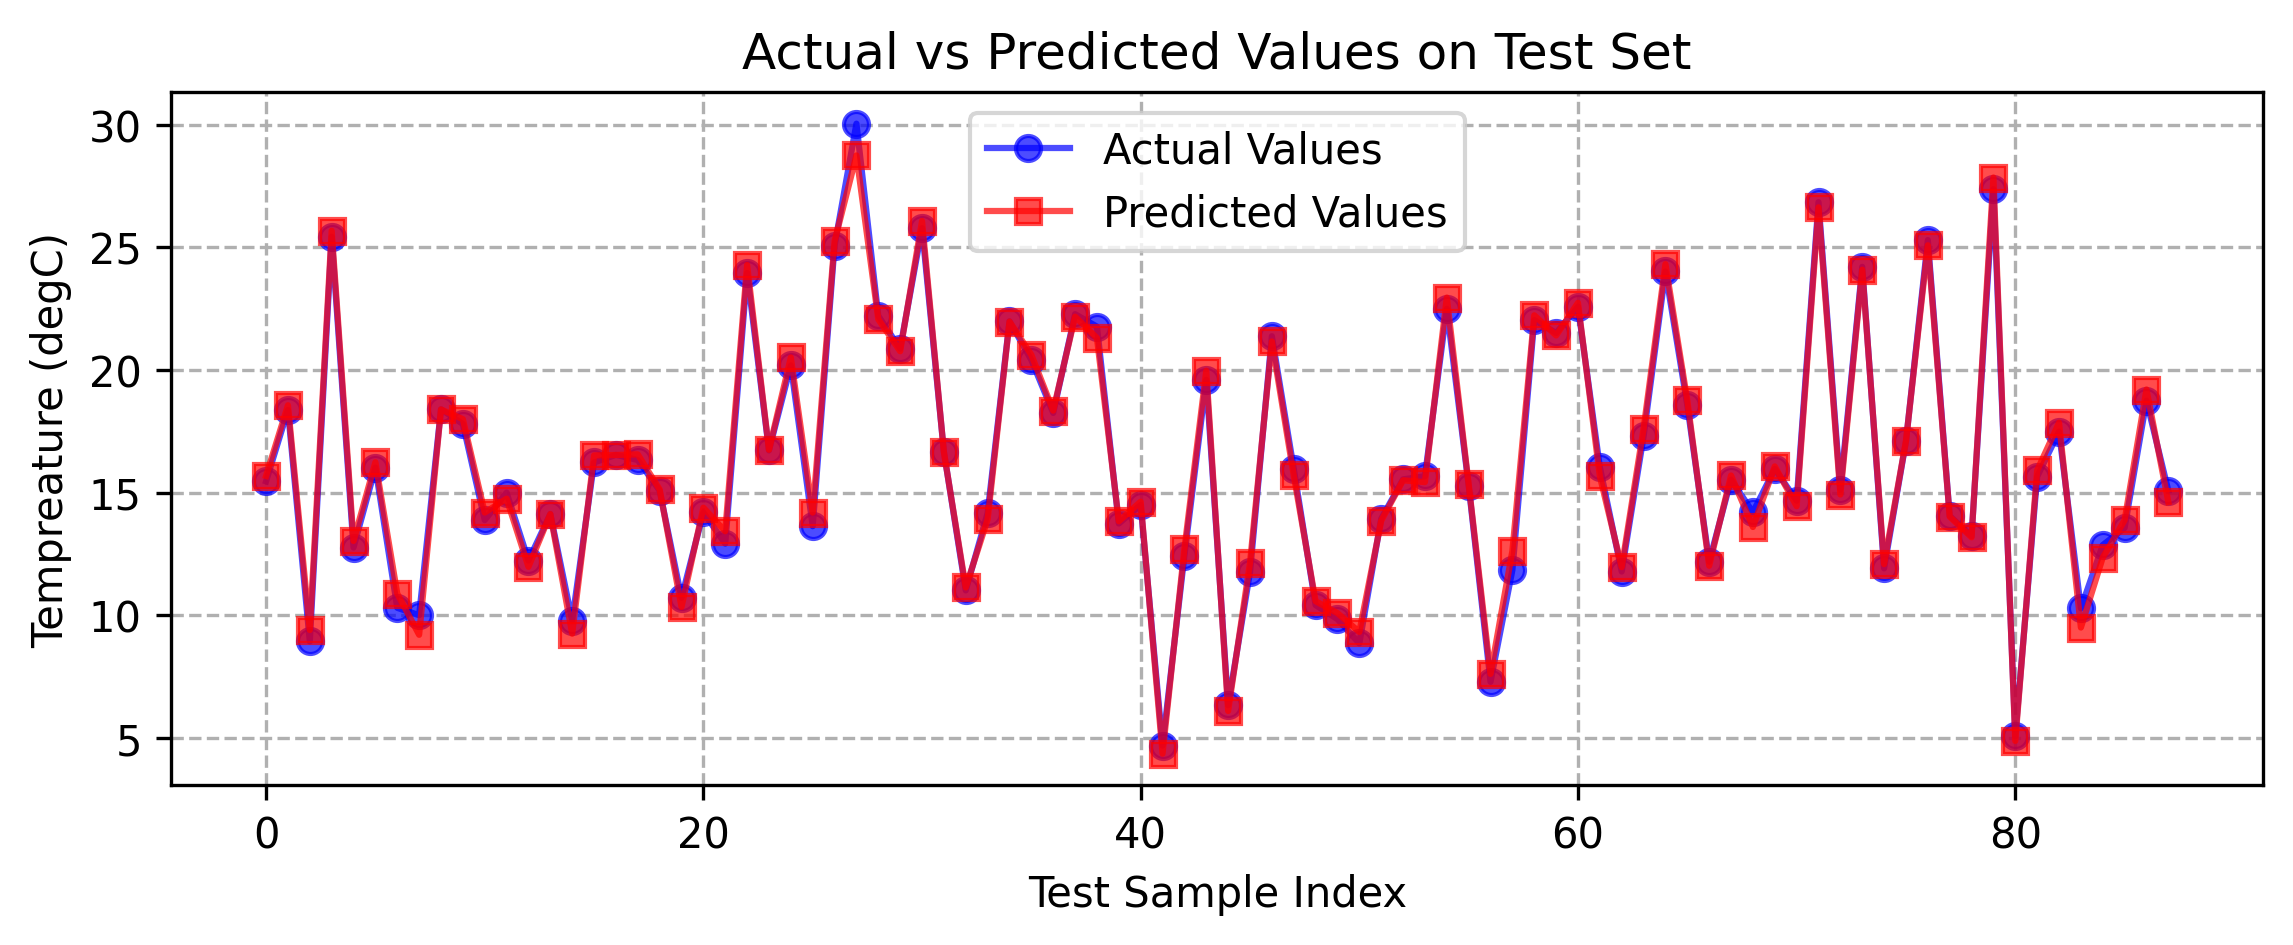

In [29]:
plt.figure(figsize=(9, 3), dpi=300)
# set the plot to display every 5th data point; otherwise, there would be too many points to distinguish.
plt.plot(y_test[::5], label="Actual Values", linestyle='-', marker='o', color='blue', alpha=0.7)
plt.plot(y_test_pred[::5], label="Predicted Values", linestyle='-', marker='s', color='red', alpha=0.7)
plt.xlabel("Test Sample Index")
plt.ylabel("Tempreature (degC)")
plt.title("Actual vs Predicted Values on Test Set")
plt.legend()
plt.grid(ls='--')
plt.show()

**Part2: Conclusions**

**1. Chosen Hyperparameters**
Based on previous analysis, the following hyperparameters were selected to optimize model performance:

- Polynomial Degree: 3 (Balances complexity and generalization)
- Learning Rate: 0.001 (Ensures stability and convergence)
- Batch Size: 128 (Balances fast learning and smooth updates)
- Regularization Method: Ridge (L2) (Provides stability and prevents overfitting)
- Penalty Term (α): 0.01 (Optimizes generalization without excessive shrinkage)
- Iterations: 300 (Ensures convergence without excessive training time)

**Further Exploration to Improve Performance**

**Experiment with Higher Polynomial Degrees:** Degree 3 worked well, but testing degrees 4-5 could capture more nonlinear relationships, provided regularization prevents overfitting.

**Adaptive Learning Rate Strategies:** Instead of a fixed learning rate, using decaying learning rates or optimizers like Adam, RMSprop, or AdaGrad may improve convergence speed and stability.

**Regularization Fine-Tuning**: Exploring different α values (e.g., 0.005 or 0.02) can refine the regularization effect for better bias-variance tradeoff.

**Batch Size Optimization:** Testing batch sizes like 64 or 256 could impact model stability, where smaller batches may improve generalization.

**Feature Engineering**: Adding interaction terms, transformations (log, square root), or domain-specific features may help uncover additional patterns in the data.

**Ensemble Methods:** Combining SGD-based regression with other models (e.g., Random Forest, Gradient Boosting, or Neural Networks) could further enhance predictive accuracy.